In [1]:
import networkx as nx
import math
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import numpy as np
from networkx import jaccard_coefficient
from scipy.spatial.distance import squareform,pdist
import seaborn as sns
import openpyxl
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.basemap import Basemap
from scipy.cluster.hierarchy import linkage, dendrogram
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os
import matplotlib.image as mpimg
from scipy.stats import pearsonr
save_data_image_path= #enter path
save_model_image_path= #enter path


In [2]:
excelEngine = pd.ExcelWriter('Model.xlsx', engine='openpyxl', mode='a')

In [3]:
#Load
df = pd.read_excel(#data)
df_lats = pd.read_excel(#longitude and latitude)
df_dest = pd.read_excel(#destination information)
df_pop = pd.read_excel(#population information)

## ---------------------------------------------- MAP -----------------------------------------------

In [4]:
graph = nx.from_pandas_edgelist(df_dest, source = 'Source', target = 'Dest',
                        edge_attr = 'Number',create_using = nx.DiGraph())
#define the map of europe
m = Basemap(
         projection='merc',
         llcrnrlon=-30,
         llcrnrlat=30,
         urcrnrlon=50,
         urcrnrlat=72,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

In [5]:
#Define the position of capital cities
#Project latitude and longitude onto the basemap surface

mx, my = m(df_lats['lat'].values, df_lats['long'].values)
pos = {}
for count, elem in enumerate (df_lats['source']):
    pos[elem] = (mx[count], my[count])

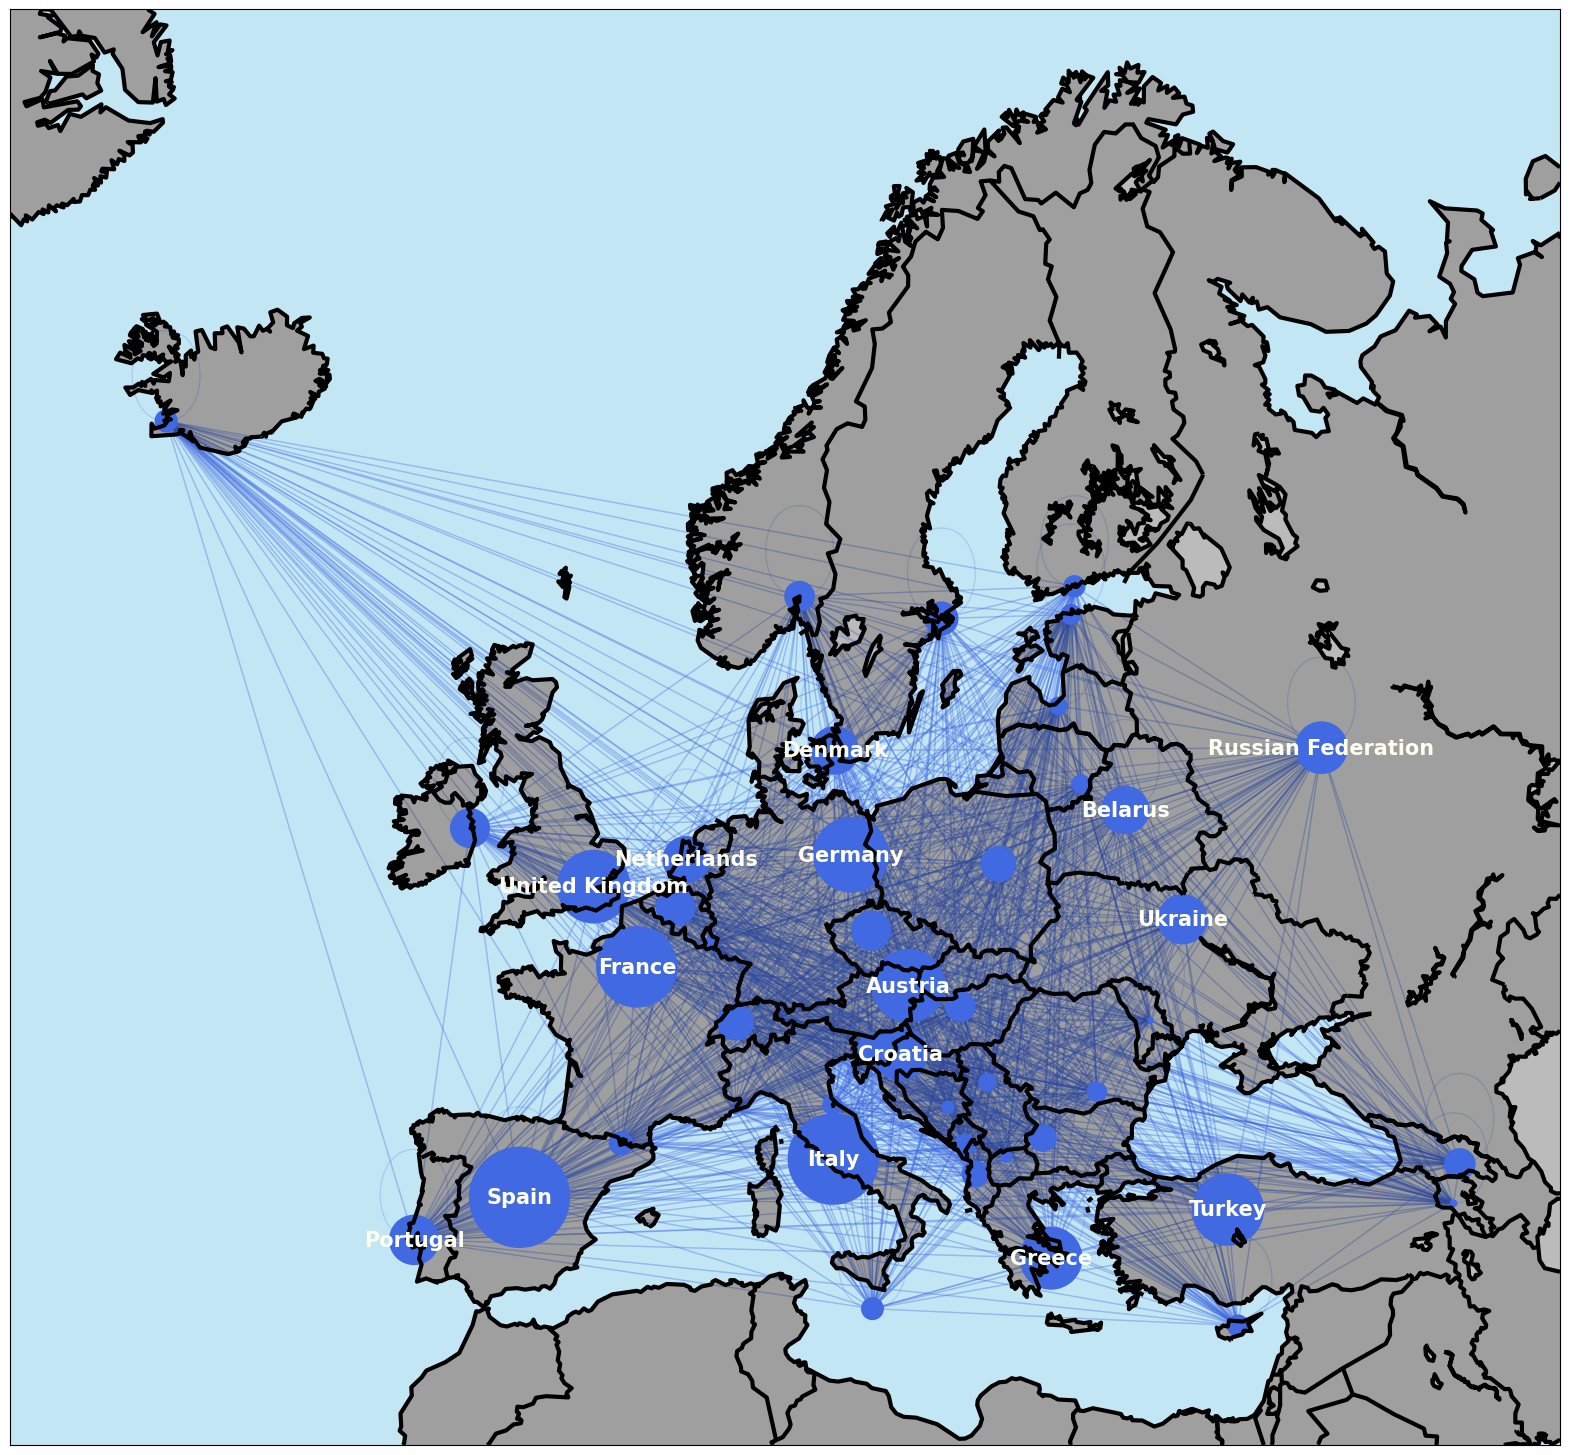

In [6]:
#Add nodes, edges, their attributes 

plt.figure(figsize = (20,20))
#nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), 
#                        node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), node_color = 'royalblue', alpha = 1,
                       node_size = [df_lats['total_in'][s]*0.0001 for s in range(0,len(graph.nodes()))])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='royalblue',
                        alpha=0.2, arrows = False)
nx.draw_networkx_labels(G = graph, pos = pos, font_size=15,font_color ='ivory',font_weight=550,
		                        labels = {y:y for x,y in zip(range(0,len(graph.nodes())),
                                graph.nodes()) if df_lats['total_in'][x] >= 8000000})

#Draw countries and coastlines, fill continent and ocean
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
m.fillcontinents(alpha = 0.3, color='black')
m.drawlsmask(alpha=0.5, ocean_color='skyblue', lakes=False)

In [7]:
coef_mat = df.to_numpy()
jacc_dist = pdist(coef_mat,metric="jaccard")
sq_form = squareform(jacc_dist)

sq_df = pd.DataFrame(sq_form,columns=[f"Node{i}" for i in range(47)])
sq_df.index = [f"Node{i}" for i in range(47)]


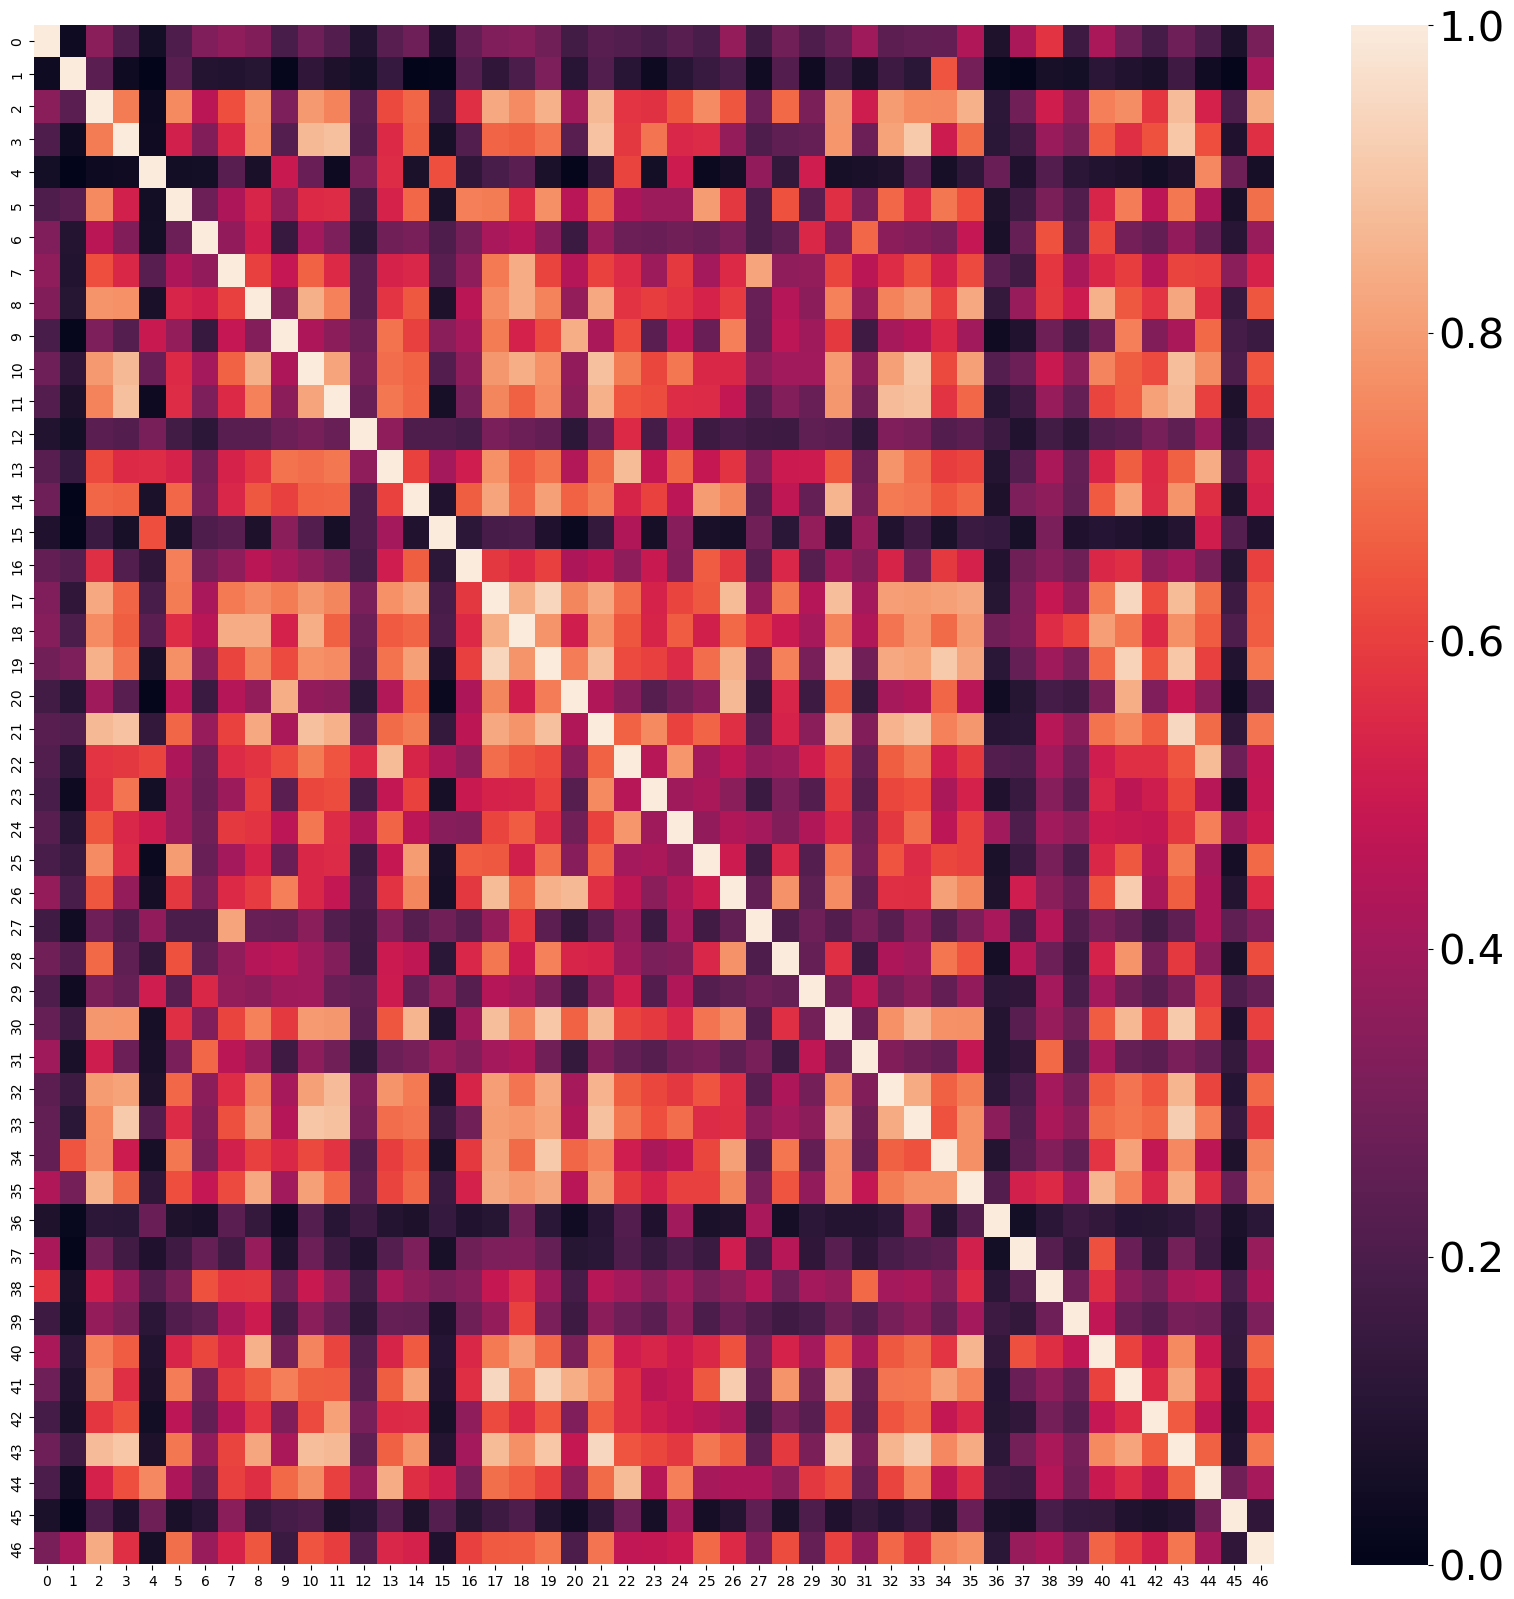

In [8]:
cos_sim_mat = cosine_similarity(coef_mat)
plt.figure(figsize = (20,20))
ax = sns.heatmap(cos_sim_mat,annot=False)
# Get the color bar object
cbar = ax.collections[0].colorbar
# Set the size of the color bar
cbar.ax.tick_params(labelsize=30)
plt.show()

# ================= Model Code - Do Not Touch ==================


In [9]:
# Define the origin-destination pairs

def distance(cont_i, cont_j):
    loni = df_lats['long'][cont_i]
    lonj = df_lats['long'][cont_j]
    lati = df_lats['lat'][cont_i]
    latj = df_lats['lat'][cont_j]
    d = haversine(lati, loni, latj, lonj)
    return d

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # radius of the earth in km
    return c * r

OD_pairs = []

for i in range(0,len(df_lats['source'])):
    for j in range(0,len(df_lats['source'])):
        OD_pairs.append((i,j))

# Define the decay function
def decay_function(distance):
    return np.exp(-distance/1000)

# Calculate the radiation model
radiation_model = {}
for o, d in OD_pairs:
    if o != d:
        radiation = 0
        S = 0
        dist_ij = distance(o,d)
        for i in range(0,len(df_lats['source'])):
            if i == o or i == d:
                continue
            if distance(o,i) <= dist_ij:
                S += df_pop['Population'][i]
        radiation = df_lats['total_out'][o] * (df_pop['Population'][o]/1000. * df_pop['Population'][d]/1000.)
        radiation = radiation / ((df_pop['Population'][o] + S)/1000. * (df_pop['Population'][o] + df_pop['Population'][d] + S)/1000.)
        radiation = radiation * decay_function(dist_ij)
        radiation_model[(df_lats['source'][o], df_lats['source'][d])] = radiation #* decay_function(nx.shortest_path_length(G, source=df_lats['source'][o], target=df_lats['source'][d]))

# Analyze the results

rad_mat = np.zeros((47,47))

for i in range(0,47):
    for j in range(0,47):
        if i != j:
            rad_mat[j,i] = radiation_model[(df_lats['source'][i],df_lats['source'][j])]

print(rad_mat)  


sorted_radiation = sorted(radiation_model.items(), key = lambda x:x[1], reverse = True)
print(sorted_radiation[:5])
print(sorted_radiation[-5:])

[[0.00000000e+00 1.72021936e-03 8.98729513e+00 ... 8.42195708e+03
  2.57793266e+03 3.39397524e+03]
 [3.26720229e-02 0.00000000e+00 7.71227946e-03 ... 2.36870880e+00
  3.54553619e+00 3.25360265e+03]
 [1.82512712e-01 3.07365566e-05 0.00000000e+00 ... 1.06752834e+04
  1.51967445e+03 9.06895549e+01]
 ...
 [1.32190299e+02 5.38538305e-03 2.23774713e+05 ... 0.00000000e+00
  2.71090378e+05 1.48516271e+04]
 [4.51666055e+01 4.10378079e-03 6.46854011e+02 ... 3.93589099e+05
  0.00000000e+00 1.51429384e+04]
 [7.42362021e+00 6.72589498e-01 4.55029512e+00 ... 1.07126166e+03
  2.61964967e+03 0.00000000e+00]]
[(('United Kingdom', 'France'), 17823140.707928468), (('Netherlands', 'Belgium'), 9387602.111539884), (('France', 'United Kingdom'), 8350820.191822657), (('Belgium', 'Netherlands'), 7949716.036224207), (('Germany', 'Czech Republic'), 7048815.230924001)]
[(('Monaco', 'Armenia'), 1.598240220412516e-05), (('San Marino', 'Armenia'), 1.3077651037676243e-05), (('Liechtenstein', 'Iceland'), 1.04919621673

# ================= K MEANS CLUSTERING =====================

## EVALUATING THE MODEL:


### Pearson Correlation

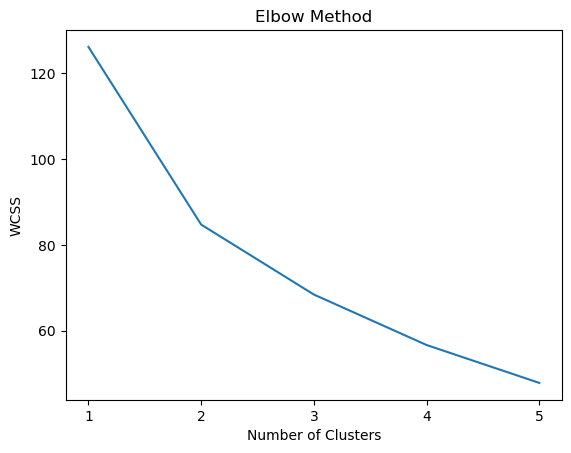

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 1 0 0 0]
0.3007792491446803


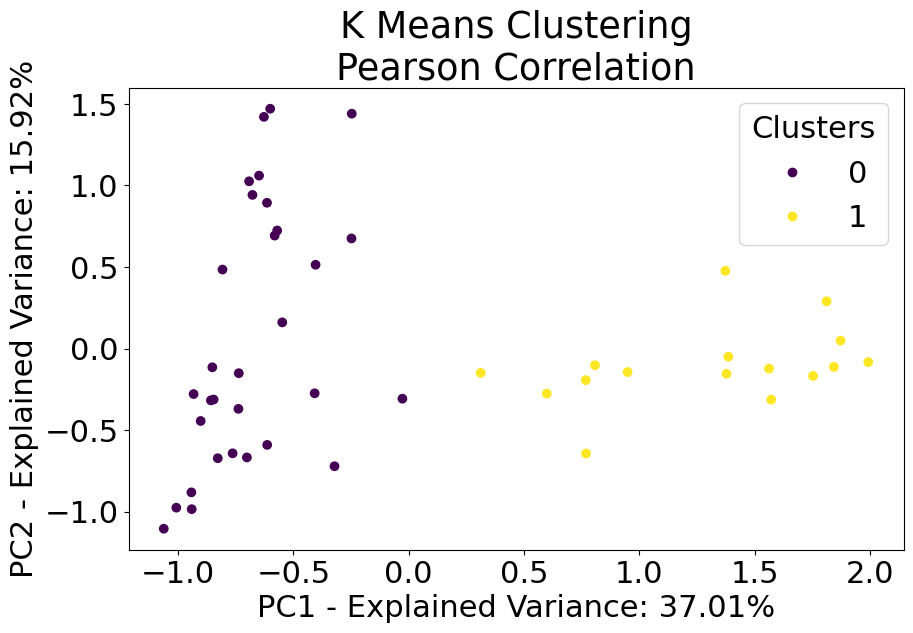

In [10]:
#K MEANS CLUSTERING - MODEL - PEARSON CORRELATION

df_Names = pd.read_excel(#country names)
df_Names = df_Names.rename(columns={0:'Country'})
#print(df_Names['Country'].values[0])
n=47
# Compute Pearson correlation matrix
pearson_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        pearson_mat[i, j], _ = pearsonr(rad_mat[i], rad_mat[j])

# Compute WCSS for k values from 1 to 10
wcss = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=50, random_state=0)
    kmeans.fit(pearson_mat)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform K-Means clustering with k clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(pearson_mat)

# Get the cluster labels for each node or edge
cluster_labels = kmeans.labels_
print(cluster_labels)


score = silhouette_score(pearson_mat,kmeans.labels_)
print(score)

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=5,value = "K Means - Pearson Correlation")
for i in range(len(cluster_labels)):
    worksheet.cell(row=i+2, column=5, value=cluster_labels[i])

# Save the workbook
workbook.save('Model.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=5,column=1,value = "K Means - Pearson Correlation")
scoresheet.cell(row=5, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
pearson_pca = pca.fit_transform(pearson_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pearson_pca[:, 0], pearson_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("K Means Clustering" +"\n"+"Pearson Correlation")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")

file_name = 'kmeans_pearson_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()


### Cosine Similarity

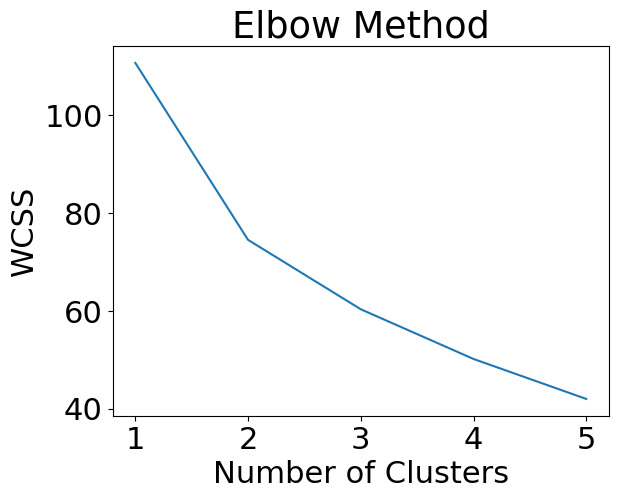

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Node Albania is assigned to cluster 1
Node Andorra is assigned to cluster 1
Node Armenia is assigned to cluster 1
Node Austria is assigned to cluster 0
Node Belarus is assigned to cluster 1
Node Belgium is assigned to cluster 1
Node Bosnia And Herzegovina is assigned to cluster 0
Node Bulgaria is assigned to cluster 1
Node Croatia is assigned to cluster 0
Node Cyprus is assigned to cluster 1
Node Czech Republic is assigned to cluster 0
Node Denmark is assigned to cluster 0
Node Estonia is assigned to cluster 1
Node Finland is assigned to cluster 1
Node France is assigned to cluster 1
Node Georgia is assigned to cluster 1
Node Germany is assigned to cluster 1
Node Greece is assigned to cluster 1
Node Hungary is assigned to cluster 0
Node Iceland is assigned to cluster 1
Node Ireland is assigned to cluster 1
Node Italy is assigned to cluster 0
Node Latvia is assigned to cluster 1
Node Liechtenstein is assigned to cluster 1
Node Lithuania is assigned to cluster 1
Node Luxembourg is assign

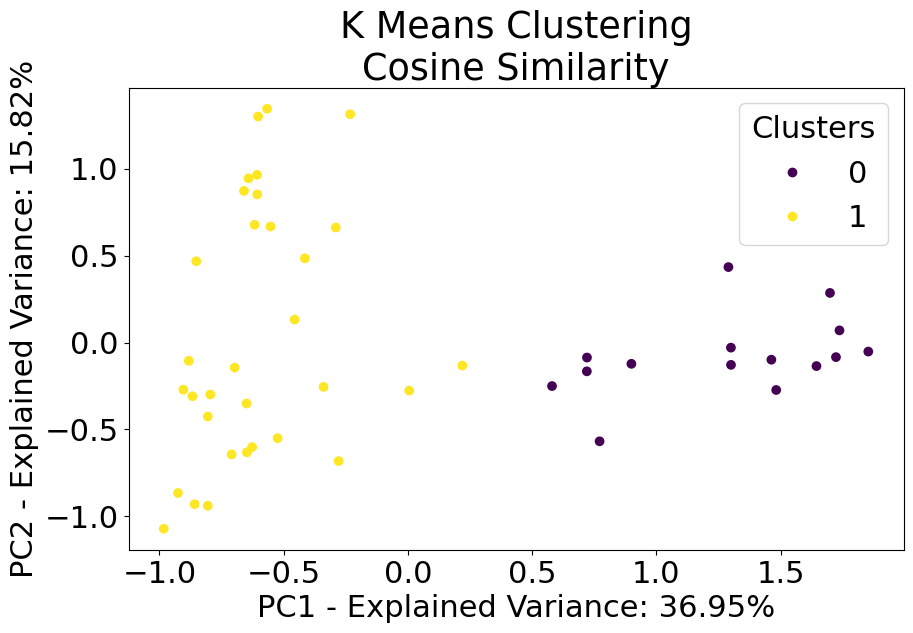

In [11]:
#K MEANS CLUSTERING -THE MODEL - COSINE SIMILARITY

rad_sim_mat = cosine_similarity(rad_mat)

# Compute WCSS for k values from 1 to 10
wcss = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=50, random_state=0)
    kmeans.fit(rad_sim_mat)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20) 
# plt.rc('')
plt.show()

# Create feature vectors for each country

# Perform K-Means clustering with k clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(rad_sim_mat)

# Get the cluster labels for each node or edge
cluster_labels = kmeans.labels_

labels = kmeans.predict(rad_sim_mat)
for i in range(len(rad_sim_mat)):
    print("Node",df_Names['Country'].values[i],"is assigned to cluster",labels[i])
print(labels)

score = silhouette_score(rad_sim_mat,kmeans.labels_)
print(score)

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=4,value = "K Means - Cosine Similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=4, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=4,column=1,value = "K Means - Cosine Similarity")
scoresheet.cell(row=4, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
cosine_pca = pca.fit_transform(rad_sim_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cosine_pca[:, 0], cosine_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("K Means Clustering" +"\n"+ "Cosine Similarity")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")

file_name = 'kmeans_cos_sim_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

## EVALUATE THE DATA:

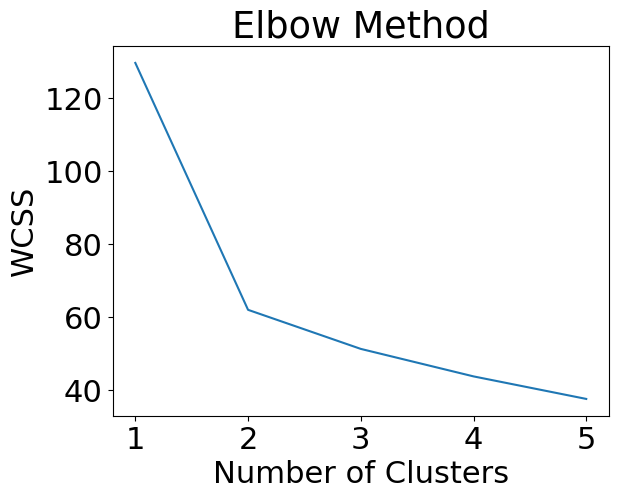

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 0 1]
0.46208780378102765


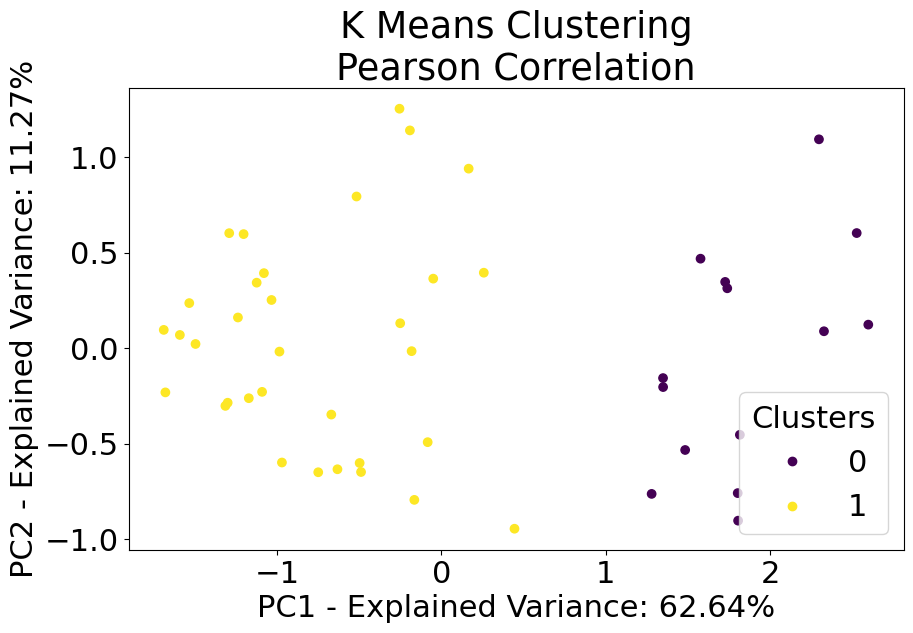

In [12]:
#K MEANS CLUSTERING - DATA - PEARSON CORRELATION

n=47
# Compute Pearson correlation matrix
pearson_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        pearson_mat[i, j], _ = pearsonr(coef_mat[i], coef_mat[j])

pearson_mat = np.nan_to_num(pearson_mat, nan=0) #Assumes NAN input is just 0

# Compute WCSS for k values from 1 to 10
wcss = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=50, random_state=0)
    kmeans.fit(pearson_mat)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform K-Means clustering with k clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(pearson_mat)

# Get the cluster labels for each node or edge
cluster_labels = kmeans.labels_
print(cluster_labels)


score = silhouette_score(pearson_mat,kmeans.labels_)
print(score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=5,value = "K Means - Pearson Correlation")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=5, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=5,column=1,value = "K Means - Pearson Correlation")
scoresheet.cell(row=5, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')


# Visualize clusters using PCA
pca = PCA(n_components=2)
pearson_pca = pca.fit_transform(pearson_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pearson_pca[:, 0], pearson_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("K Means Clustering" + "\n"+"Pearson Correlation")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")
file_name = 'kmeans_pearson_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

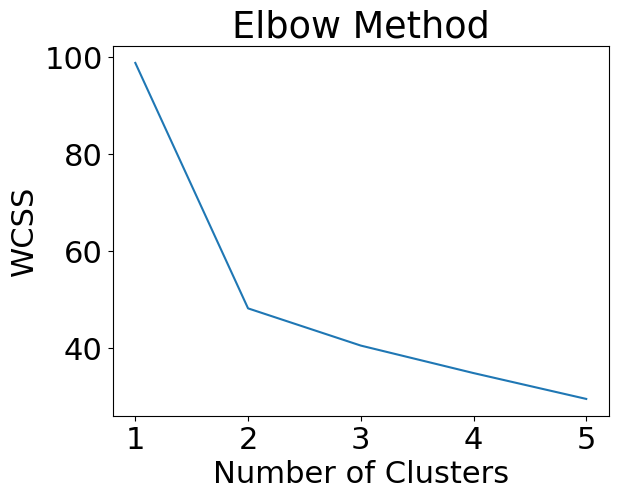

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Node 0 is assigned to cluster 1
Node 1 is assigned to cluster 1
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster 1
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 1
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster 1
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster 1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 0
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster 1
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster 1
Node 30 is assigned 

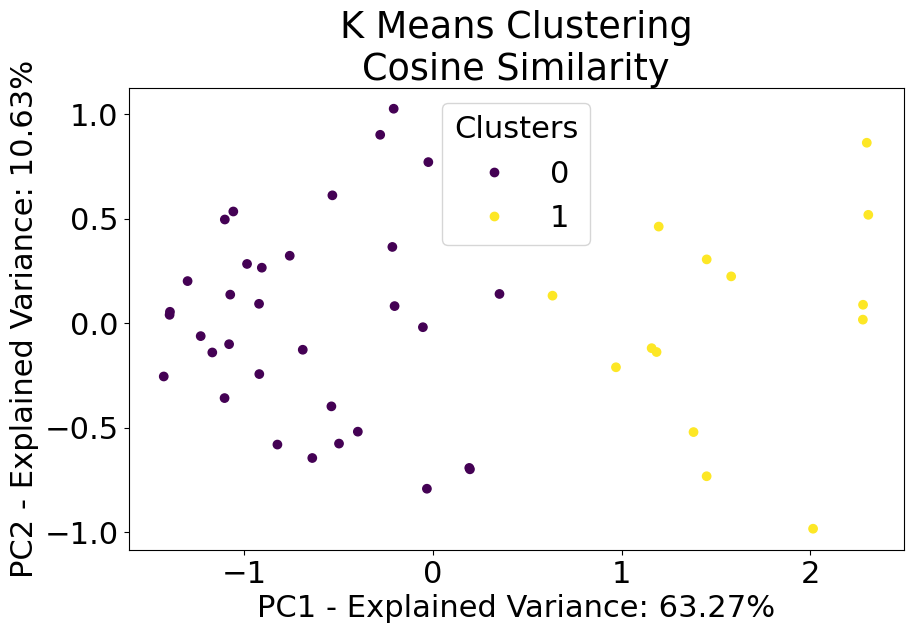

In [13]:
#K MEANS CLUSTERING -DATA - COSINE SIMILARITY

coef_sim_mat = cosine_similarity(coef_mat)

# Compute WCSS for k values from 1 to 10
wcss = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=50, random_state=0)
    kmeans.fit(coef_sim_mat)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20) 
# plt.rc('')
plt.show()

# Create feature vectors for each country

# Perform K-Means clustering with k clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(coef_sim_mat)

# Get the cluster labels for each node or edge
cluster_labels = kmeans.labels_

labels = kmeans.predict(coef_sim_mat)
for i in range(len(coef_sim_mat)):
    print("Node",i,"is assigned to cluster",labels[i])
print(labels)

score = silhouette_score(coef_sim_mat,kmeans.labels_)
print(score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=4,value = "K Means - Cosine Similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=4, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=4,column=1,value = "K Means - Cosine Similarity")
scoresheet.cell(row=4, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')


# Visualize clusters using PCA
pca = PCA(n_components=2)
cosine_pca = pca.fit_transform(coef_sim_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cosine_pca[:, 0], cosine_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("K Means Clustering" + "\n"+"Cosine Similarity")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")
file_name = 'kmeans_cos_sim_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

# ======================== DBSCAN ===========================

## EVALUATING THE MODEL:



### Cosine Similarity

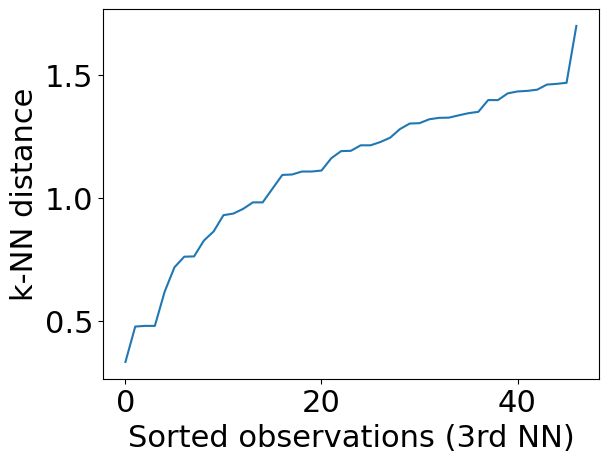

1.3967553494532434


In [14]:
#DBSCAN for model - cosine similarity

rad_sim_mat = cosine_similarity(rad_mat)

# n_neighbors = 9 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 9).fit(rad_sim_mat)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(rad_sim_mat)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:,3]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (3rd NN)")
plt.show()

from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
# get the estimate of knee point
print(kneedle.knee_y)

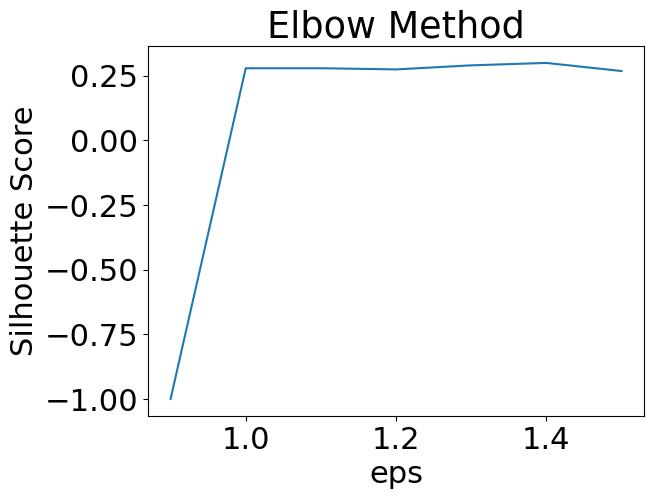

Node 0 is assigned to cluster -1
Node 1 is assigned to cluster 0
Node 2 is assigned to cluster 1
Node 3 is assigned to cluster 2
Node 4 is assigned to cluster 3
Node 5 is assigned to cluster 4
Node 6 is assigned to cluster 2
Node 7 is assigned to cluster 5
Node 8 is assigned to cluster 2
Node 9 is assigned to cluster -1
Node 10 is assigned to cluster 2
Node 11 is assigned to cluster 2
Node 12 is assigned to cluster 6
Node 13 is assigned to cluster -1
Node 14 is assigned to cluster 7
Node 15 is assigned to cluster -1
Node 16 is assigned to cluster -1
Node 17 is assigned to cluster 5
Node 18 is assigned to cluster 2
Node 19 is assigned to cluster 7
Node 20 is assigned to cluster 7
Node 21 is assigned to cluster 2
Node 22 is assigned to cluster 6
Node 23 is assigned to cluster 4
Node 24 is assigned to cluster 6
Node 25 is assigned to cluster 4
Node 26 is assigned to cluster 2
Node 27 is assigned to cluster 3
Node 28 is assigned to cluster 4
Node 29 is assigned to cluster 2
Node 30 is assi

In [15]:
#DBSCAN - MODEL - cosine similarity

# Compute elbow score for different values of eps
eps_values = [0.9,1.0,1.1,1.2,1.3,1.4,1.5]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=9)
    labels = model.fit_predict(rad_sim_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(rad_sim_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering with knee value
model = DBSCAN(eps=1.1, min_samples=2)
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=2,column=1,value = "DBSCAN - Cosine Similarity")
scoresheet.cell(row=2, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

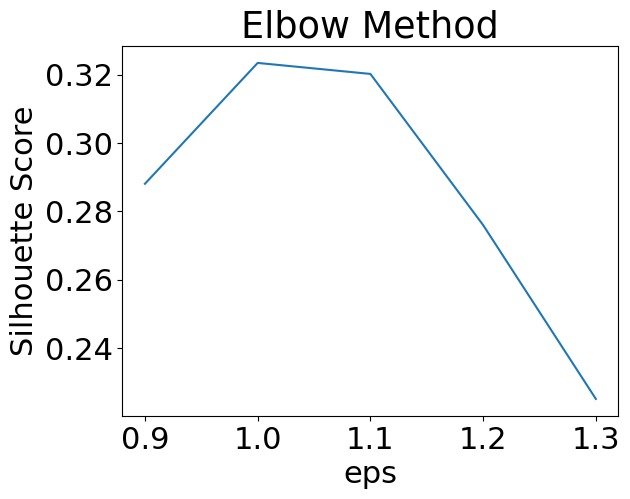

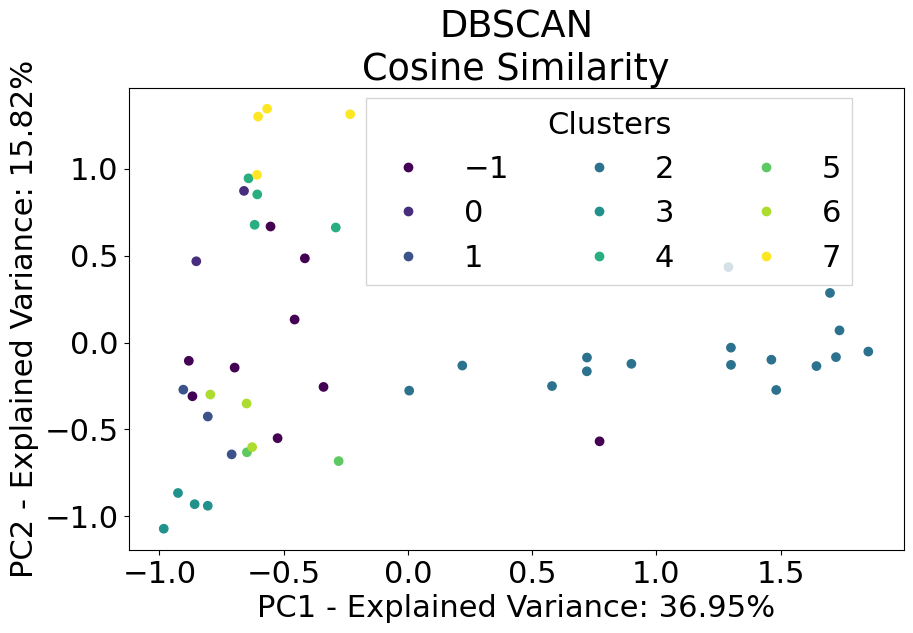

In [16]:
#DBSCAN - MODEL - Cosine Similarity

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

rad_sim_mat = cosine_similarity(rad_mat)

# Compute elbow score for different values of eps
eps_values = [0.9,1,1.1,1.2,1.3]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=2)
    labels = model.fit_predict(rad_sim_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(rad_sim_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering
model = DBSCAN(eps=1.1, min_samples=2)
labels = model.fit_predict(rad_sim_mat)

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=2,value = "DBSCAN - Cosine Similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=2, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN" +"\n"+ "Cosine Similarity")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters",loc ="upper center",bbox_to_anchor=(0.62, 1.01), fancybox=False, shadow=False, ncol=3)
file_name = 'DBSCAN_cos_sim_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

### Pearson Correlation

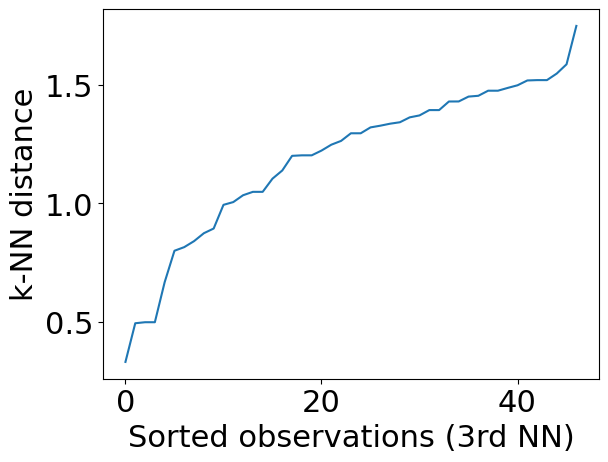

1.4303407191314599


In [17]:
#DBSCAN - MODEL - Pearson Correlation

n=47
# Compute Pearson correlation matrix
pearson_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        pearson_mat[i, j], _ = pearsonr(rad_mat[i], rad_mat[j])


# n_neighbors = 10 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 10).fit(pearson_mat)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pearson_mat)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 3]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (3rd NN)")
plt.show()

from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
# get the estimate of knee point
print(kneedle.knee_y)


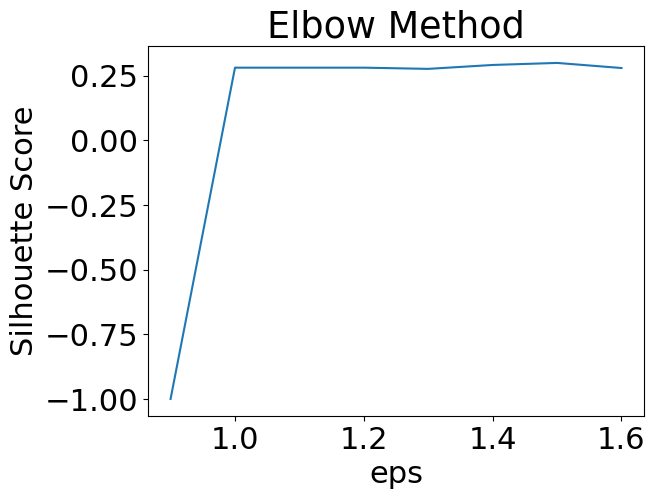

Node 0 is assigned to cluster -1
Node 1 is assigned to cluster -1
Node 2 is assigned to cluster -1
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster -1
Node 5 is assigned to cluster -1
Node 6 is assigned to cluster 0
Node 7 is assigned to cluster -1
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster -1
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster -1
Node 13 is assigned to cluster -1
Node 14 is assigned to cluster -1
Node 15 is assigned to cluster -1
Node 16 is assigned to cluster -1
Node 17 is assigned to cluster -1
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster -1
Node 20 is assigned to cluster -1
Node 21 is assigned to cluster 0
Node 22 is assigned to cluster -1
Node 23 is assigned to cluster -1
Node 24 is assigned to cluster -1
Node 25 is assigned to cluster -1
Node 26 is assigned to cluster -1
Node 27 is assigned to cluster -1
Node 28 is assigned to cluster -1
Node 29 is assigned to cluster 

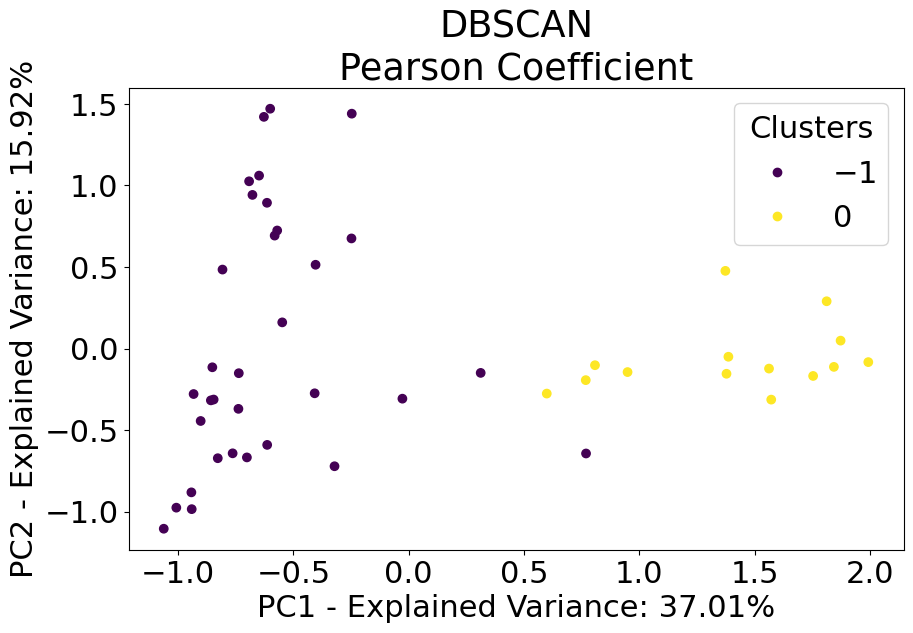

In [18]:
#DBSCAN - MODEL - Pearson Correlation

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Compute elbow score for different values of eps
eps_values = [0.9,1,1.1,1.2,1.3,1.4,1.5,1.6]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=9)
    labels = model.fit_predict(pearson_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(pearson_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering
model = DBSCAN(eps=1.43, min_samples=8)
labels = model.fit_predict(pearson_mat)

# Print the cluster labels for each node or edge
for i in range(len(pearson_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(pearson_mat, labels)
print("Silhouette score:", score)

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=3,value = "DBSCAN - Pearson Correlation")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=3, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=3,column=1,value = "DBSCAN - Pearson Correlation")
scoresheet.cell(row=3, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')


# Perform PCA
pca = PCA(n_components=2)
pearson_pca = pca.fit_transform(pearson_mat)
# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pearson_pca[:, 0], pearson_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN" +"\n"+ "Pearson Coefficient")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")
file_name = 'DBSCAN_pearson_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

## EVALUATING REAL DATA:



### Cosine Similarity

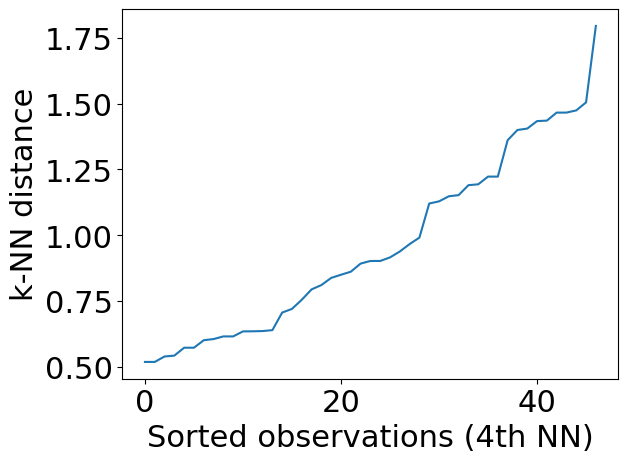

1.4655603408021842


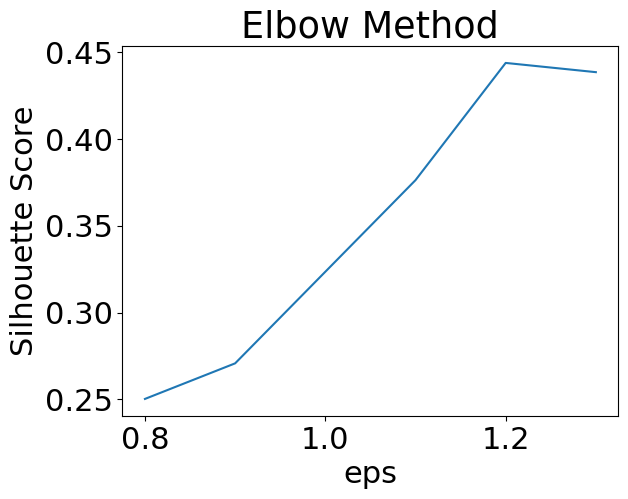

Node 0 is assigned to cluster -1
Node 1 is assigned to cluster -1
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster -1
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster -1
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster -1
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster -1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 0
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster -1
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster -1
Node 30 is a

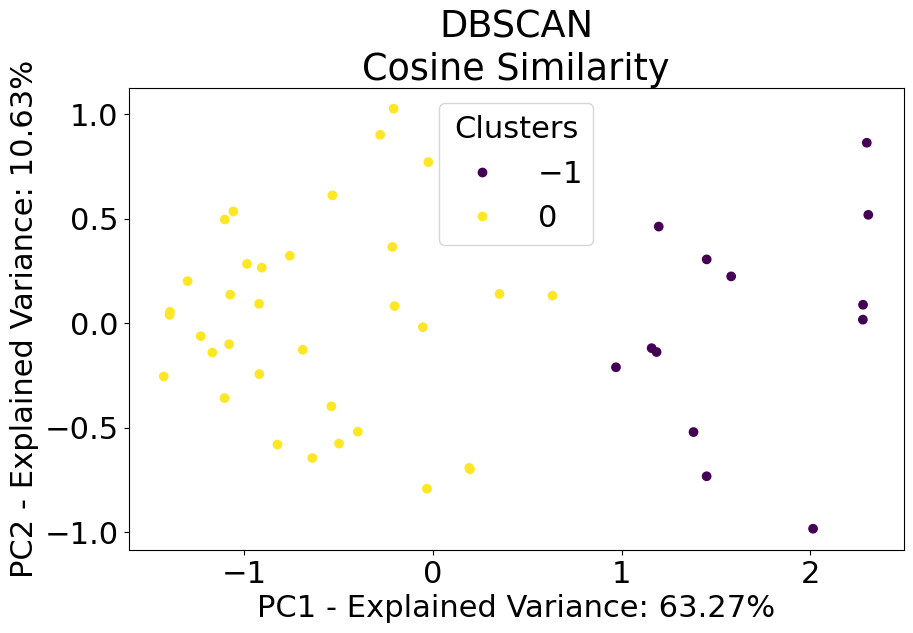

In [19]:
#DBSCAN - DATA - Cosine Similarity

cos_sim_mat = cosine_similarity(coef_mat)

# n_neighbors = 9 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 9).fit(cos_sim_mat)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(cos_sim_mat)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 3]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
# get the estimate of knee point
print(kneedle.knee_y)
# Compute elbow score for different values of eps
eps_values = [0.8, 0.9,1.1,1.2,1.3]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=8)
    labels = model.fit_predict(cos_sim_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(cos_sim_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering
model = DBSCAN(eps=1.465, min_samples=9)
labels = model.fit_predict(cos_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(cos_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(cos_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=2,column=1,value = "DBSCAN- Cosine Similarity")
scoresheet.cell(row=2, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')

# Perform PCA
pca = PCA(n_components=2)
cos_sim_pca = pca.fit_transform(cos_sim_mat)

# Plot the PCA visualization with cluster labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cos_sim_pca[:, 0], cos_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN" +"\n"+ "Cosine Similarity")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")
file_name = 'DBSCAN_cos_sim_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

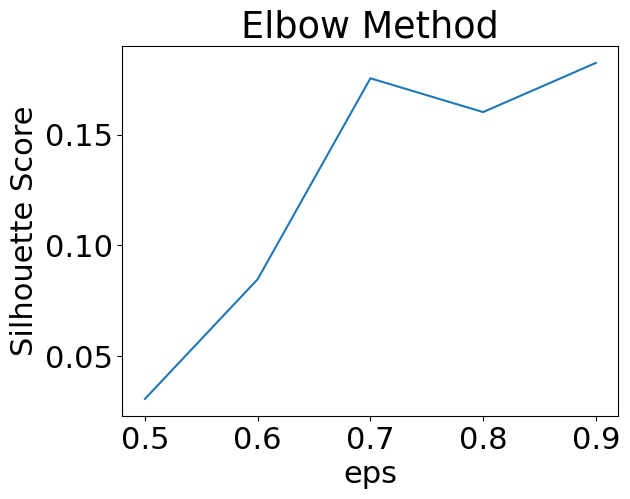

In [20]:
#DBSCAN - DATA - Cosine Similarity

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Compute elbow score for different values of eps
eps_values = [0.5, 0.6, 0.7, 0.8, 0.9]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=3)
    labels = model.fit_predict(cos_sim_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(cos_sim_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering
model = DBSCAN(eps=1.465, min_samples=9)
labels = model.fit_predict(cos_sim_mat)

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=2,value = "DBSCAN - Cosine Similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=2, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')

### Pearson Correlation

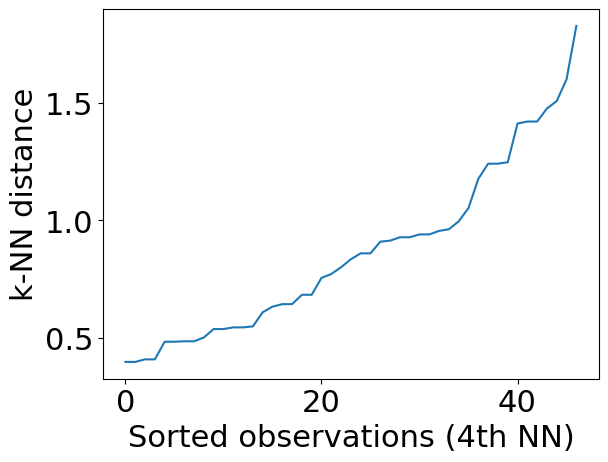

1.4124901145826536


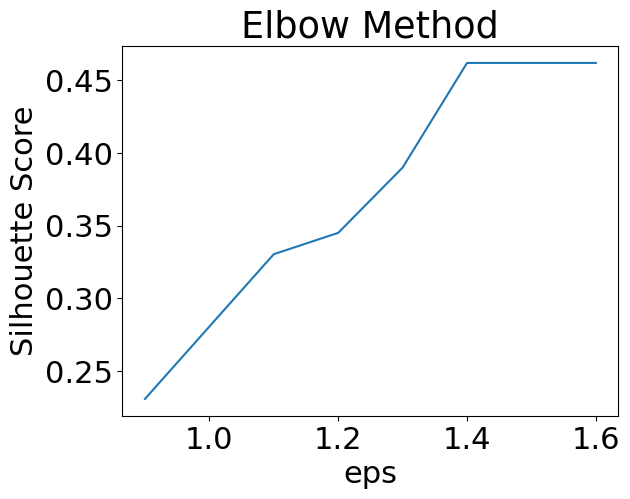

Node 0 is assigned to cluster -1
Node 1 is assigned to cluster -1
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster -1
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster -1
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster -1
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster -1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 0
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster -1
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster -1
Node 30 is a

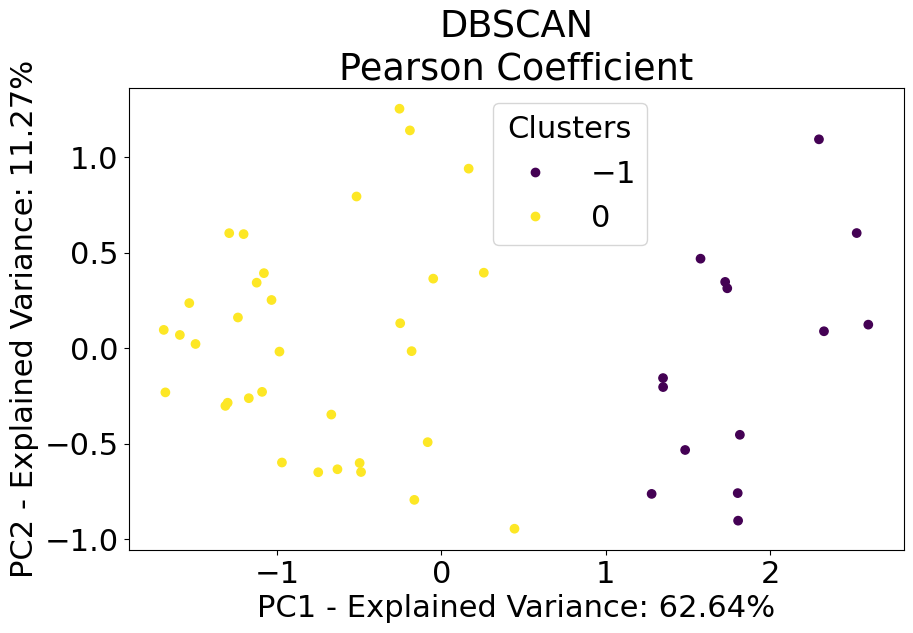

In [21]:
#DBSCAN - DATA - Pearson Correlation

n=47
# Compute Pearson correlation matrix
pearson_mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        pearson_mat[i, j], _ = pearsonr(coef_mat[i], coef_mat[j])

pearson_mat = np.nan_to_num(pearson_mat, nan=0) #Assumes NAN input is just 0

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 2).fit(pearson_mat)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pearson_mat)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

k_dist = sort_neigh_dist[:, 1]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
# get the estimate of knee point
print(kneedle.knee_y)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Compute elbow score for different values of eps
eps_values = [0.9,1.1,1.2,1.3,1.4,1.5,1.6]
elbow_scores = []
for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=9)
    labels = model.fit_predict(pearson_mat)
    if len(set(labels)) > 1:
        elbow_scores.append(silhouette_score(pearson_mat, labels))
    else:
        elbow_scores.append(-1)

# Plot the elbow curve
plt.plot(eps_values, elbow_scores)
plt.title('Elbow Method')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform DBSCAN clustering
model = DBSCAN(eps=1.41, min_samples=7)
labels = model.fit_predict(pearson_mat)

# Print the cluster labels for each node or edge
for i in range(len(pearson_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(pearson_mat, labels)
print("Silhouette score:", score)

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=3,value = "DBSCAN - Pearson Correlation")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=3, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=3,column=1,value = "DBSCAN-Pearson Correlation")
scoresheet.cell(row=3, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')

# Perform PCA
pca = PCA(n_components=2)
pearson_pca = pca.fit_transform(pearson_mat)

# Plot the PCA visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pearson_pca[:, 0], pearson_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN" +"\n"+ "Pearson Coefficient")
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters",bbox_to_anchor=(0.45, 1)) 
file_name = 'DBSCAN_pearson_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()


# ============== AGGLOMERATIVE CLUSTERING ===================


## EVALUATE THE MODEL:

### Euclidean Distance

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

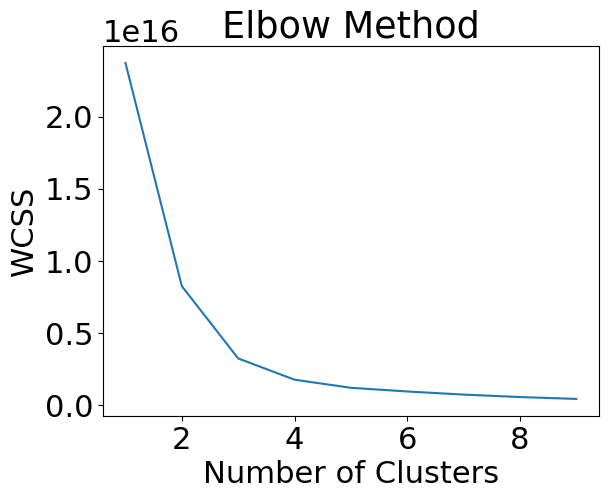

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Node 0 is assigned to cluster 1
Node 1 is assigned to cluster 1
Node 2 is assigned to cluster 1
Node 3 is assigned to cluster 1
Node 4 is assigned to cluster 1
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 1
Node 7 is assigned to cluster 1
Node 8 is assigned to cluster 1
Node 9 is assigned to cluster 1
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 1
Node 12 is assigned to cluster 1
Node 13 is assigned to cluster 1
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster 1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 1
Node 18 is assigned to cluster 1
Node 19 is assigned to cluster 1
Node 20 is assigned to cluster 1
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 1
Node 23 is assigned to cluster 1
Node 24 is assigned to cluster 1
Node 25 is assigned to cluster 1
Node 26 is assigned to cluster 1
Node 27 is assigned to cluster 1
Node 28 is assigned to cluster 1
Node 29 is assigned to cluster 1
Node 30 is assigned 

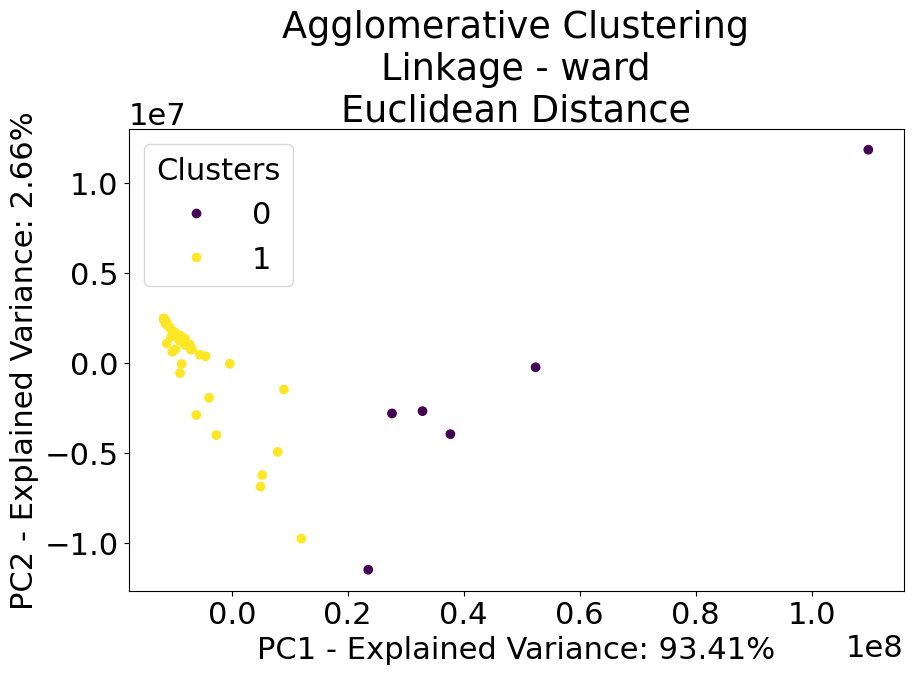

/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/2686899306.py:127: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(rad_sim_mat, method='ward')


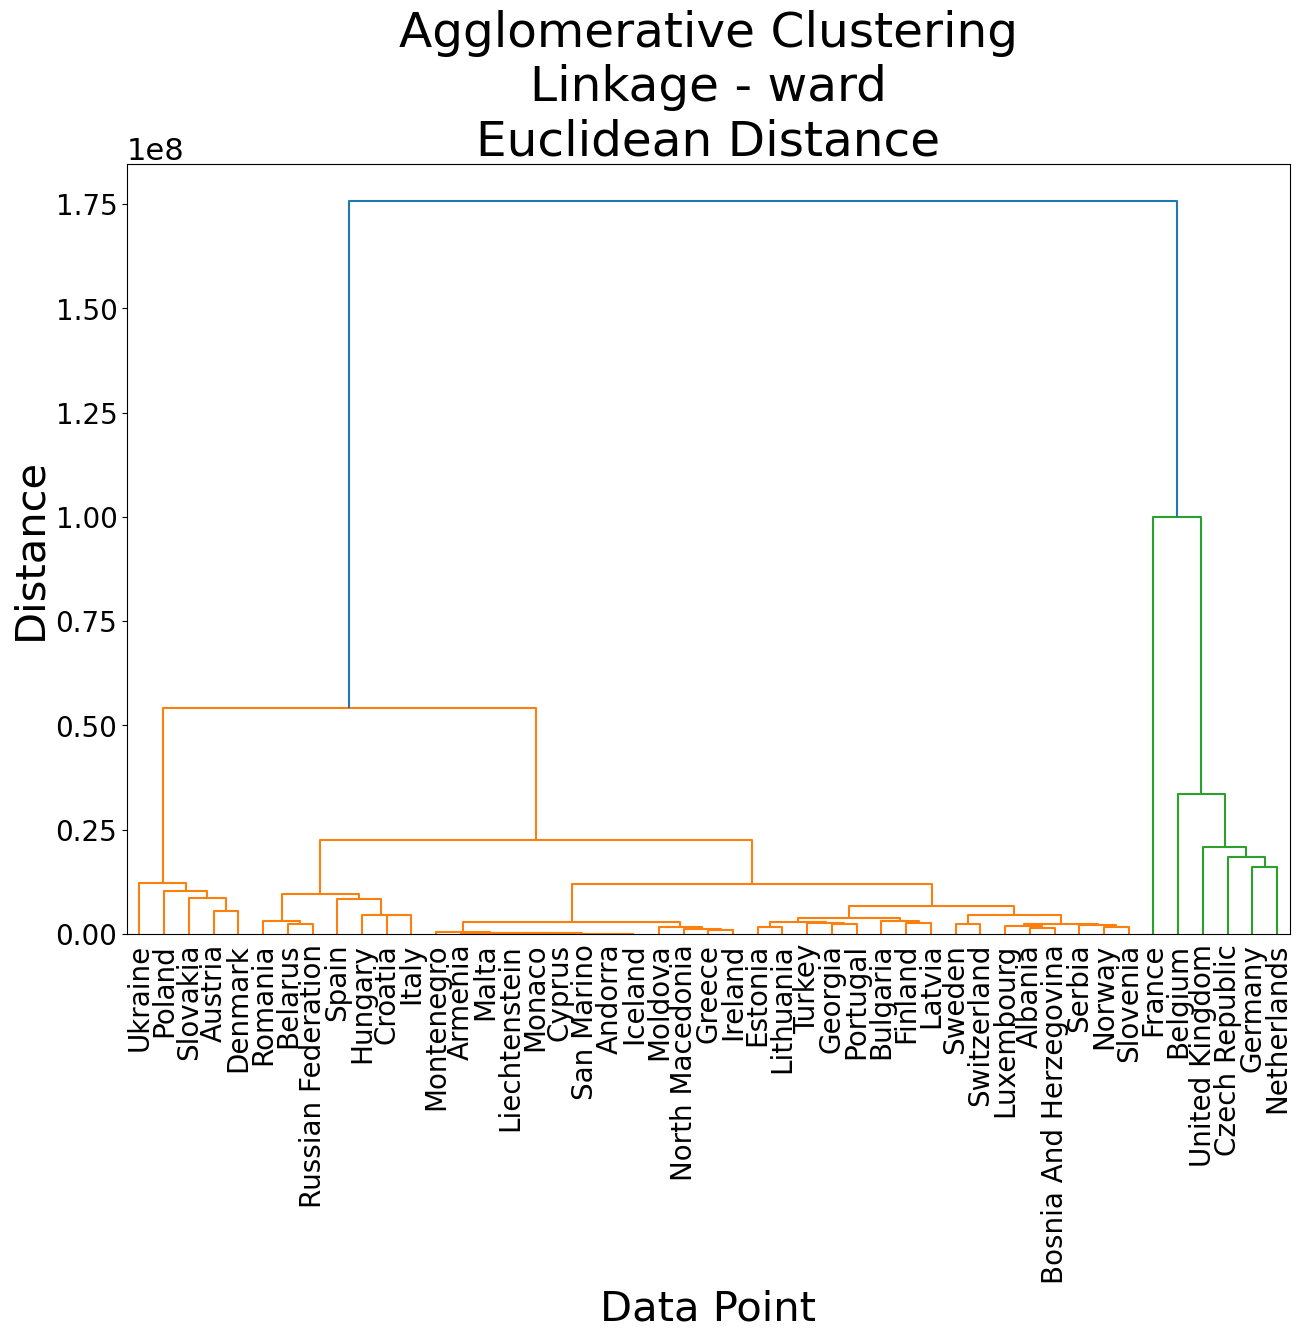

In [47]:
#AGGLOMERATIVE CLUSTERING - THE MODEL

#EUCLIDEAN DISTANCE

rad_sim_mat = euclidean_distances(rad_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 10):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 10), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='ward')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=6,value = "Agglomerative - Euclidean distance")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=6, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=6,column=1,value = "Agglomerative - Euclidean distance")
scoresheet.cell(row=6, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')


# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)


# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=6,value = "Agglomerative - Euclidean distance")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=6, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=6,column=1,value = "Agglomerative - Euclidean distance")
scoresheet.cell(row=6, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Euclidean Distance")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')

# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
file_name = 'agglo_euclidean_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight') 
plt.show()

# Plot the dendrogram
Z = linkage(rad_sim_mat, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=df_Names['Country'].values)
plt.xlabel('Data Point', fontsize=30)
plt.ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+ "Euclidean Distance", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Model/dendro_euc_19.png', bbox_inches='tight')
plt.show()




### Cosine Similarity

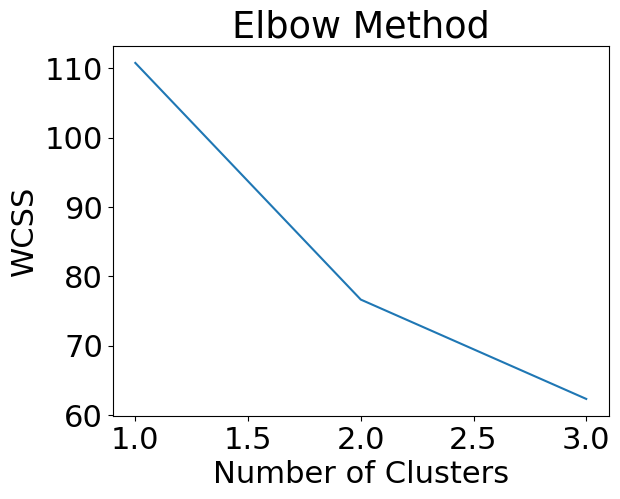

Node 0 is assigned to cluster 0
Node 1 is assigned to cluster 0
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 1
Node 4 is assigned to cluster 0
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 0
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 1
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 1
Node 11 is assigned to cluster 1
Node 12 is assigned to cluster 0
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster 0
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 1
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster 0
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster 0
Node 30 is assigned 

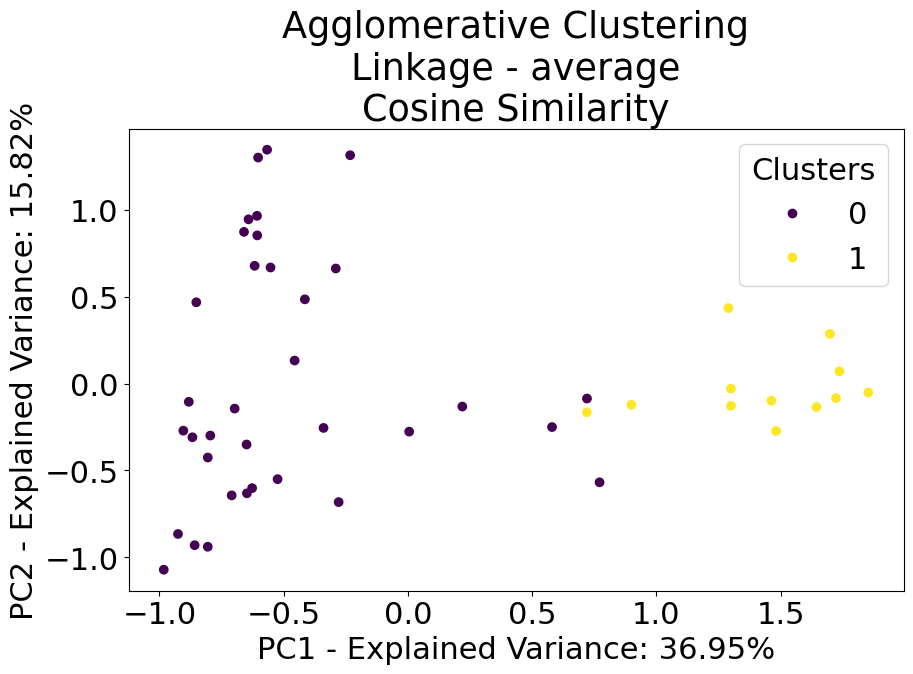

In [50]:
#AGGLOMERATIVE CLUSTERING - THE MODEL

## COSINE SIMILARITY
rad_sim_mat = cosine_similarity(rad_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 4):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 4), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='average')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active


# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=7,value = "Agglomerative - Cosine similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=7, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=7,column=1,value = "Agglomerative - Cosine similarity")
scoresheet.cell(row=7, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - average"+ "\n"+  "Cosine Similarity")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')

# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
file_name = 'agglo_cos_sim_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()



### MANHATTAN DISTANCE K=2 

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

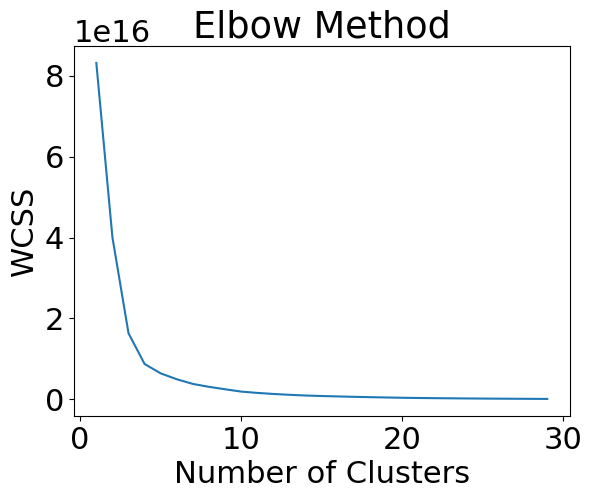

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/2944733382.py:67: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cos_sim_mat,'ward')


Node 0 is assigned to cluster 1
Node 1 is assigned to cluster 1
Node 2 is assigned to cluster 1
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster 1
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 1
Node 7 is assigned to cluster 1
Node 8 is assigned to cluster 1
Node 9 is assigned to cluster 1
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster 1
Node 13 is assigned to cluster 1
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster 1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 1
Node 18 is assigned to cluster 1
Node 19 is assigned to cluster 1
Node 20 is assigned to cluster 1
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 1
Node 23 is assigned to cluster 1
Node 24 is assigned to cluster 1
Node 25 is assigned to cluster 1
Node 26 is assigned to cluster 1
Node 27 is assigned to cluster 1
Node 28 is assigned to cluster 1
Node 29 is assigned to cluster 1
Node 30 is assigned 

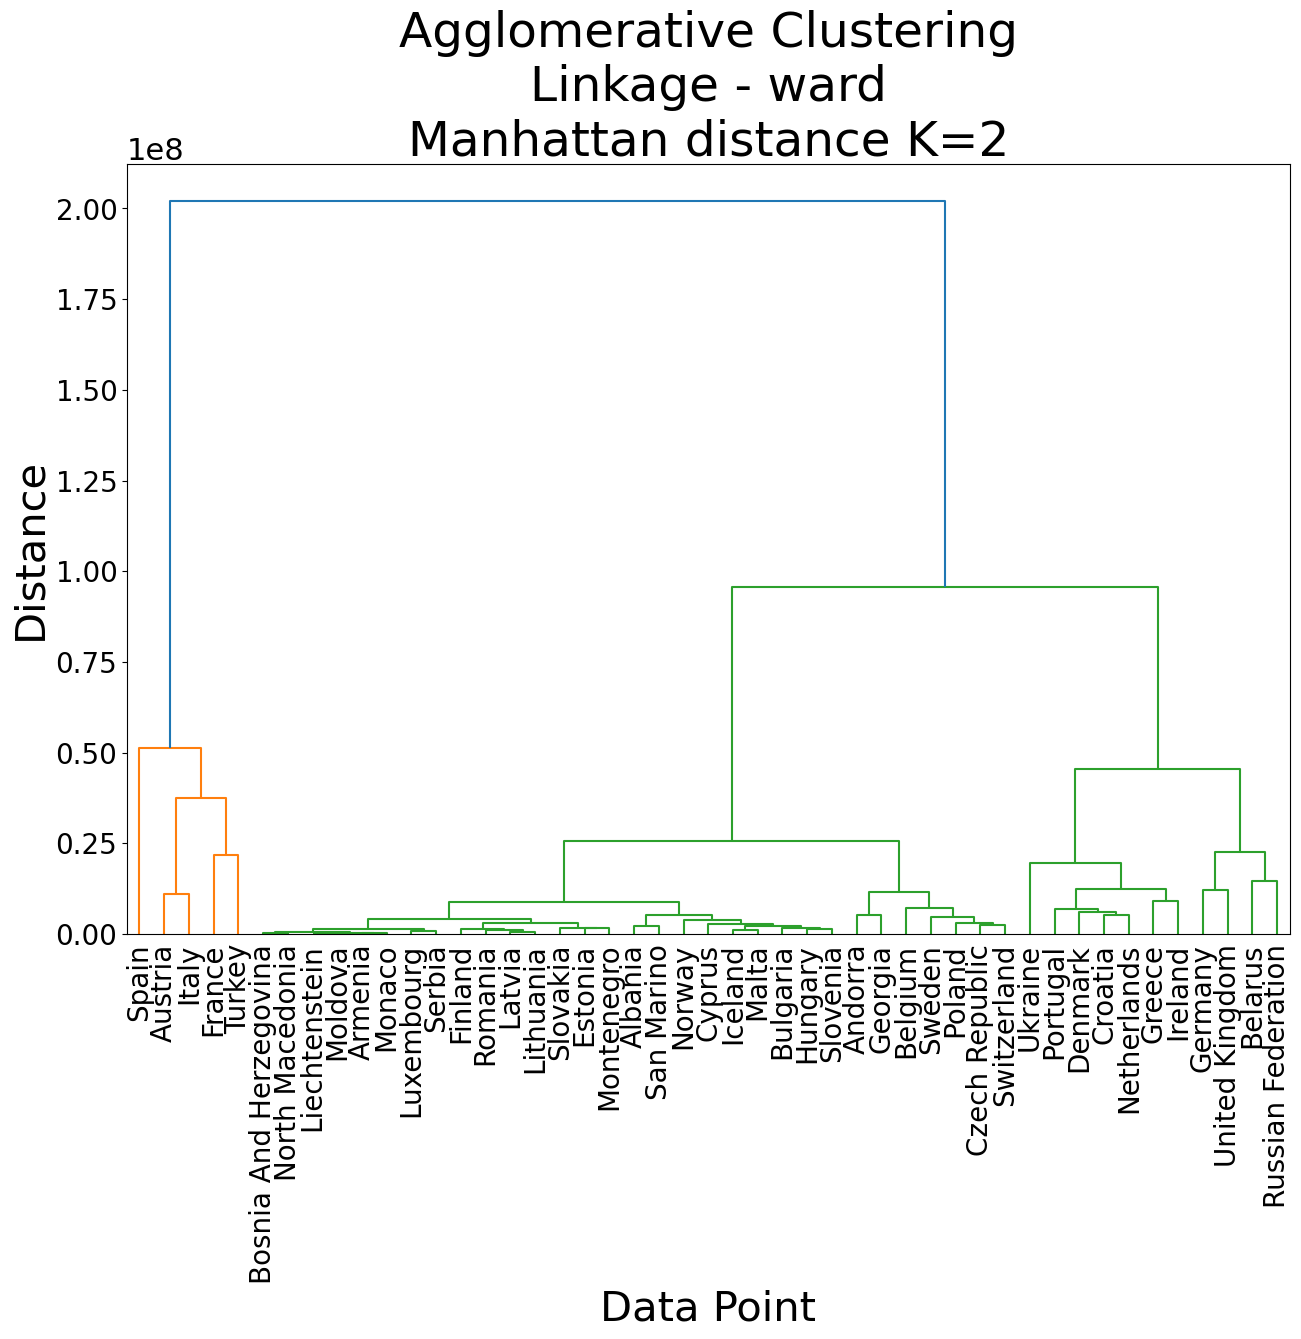

PC1 Explained Variance: 91.27%
PC2 Explained Variance: 2.93%


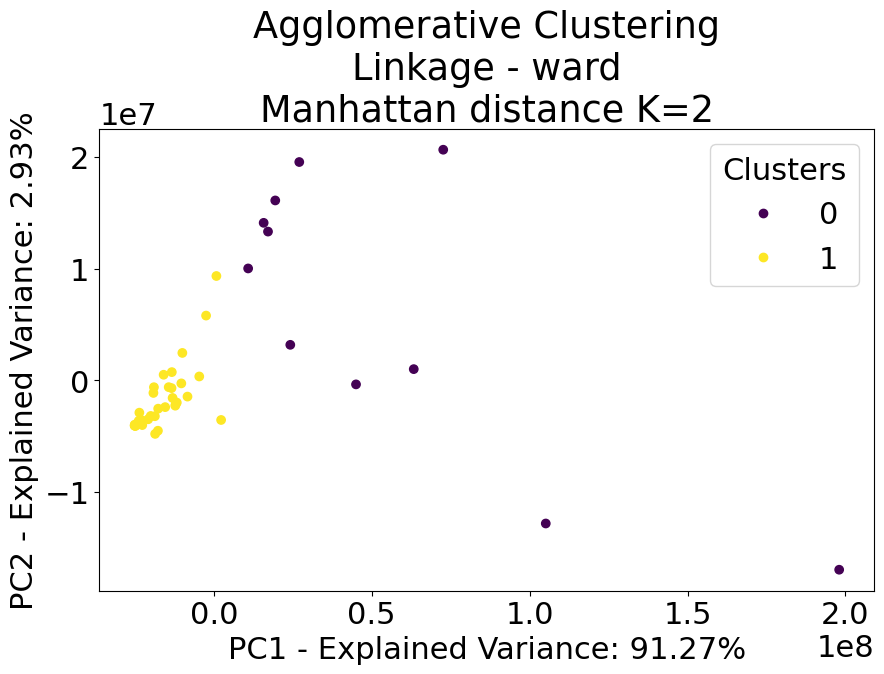

In [45]:
rad_sim_mat = manhattan_distances(rad_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 30):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 30), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='ward')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=8,column=1,value = "Agglomerative - Manhattan distance K=2")
scoresheet.cell(row=8, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=8,value = "Agglomerative - Manhattan distance K=2")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=8, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')
label_dict = {number : country for number, country in zip(df_Names.index.values, df_Names['Country'].values)}



#Plot the dendrogram
Z = linkage(cos_sim_mat,'ward')
fig,ax = plt.subplots(figsize=(15,10))
dendrogram(Z,ax=ax,labels=df_Names['Country'].values)
ax.set_xlabel('Data Point', fontsize=30)
ax.set_ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Manhattan distance K=2", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Model/dendro_agglo_k2_19.png', bbox_inches='tight')
plt.show()

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Manhattan distance K=2")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')

# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
file_name = 'agglo_manhattan_2_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()



### MANHATTAN DISTANCE K=3 clusters

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

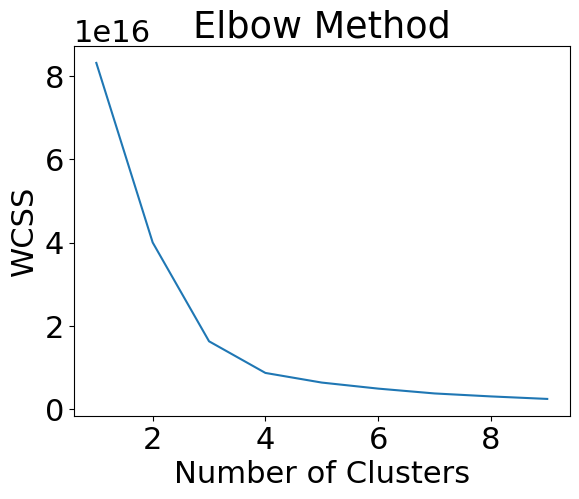

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Node 0 is assigned to cluster 2
Node 1 is assigned to cluster 2
Node 2 is assigned to cluster 2
Node 3 is assigned to cluster 2
Node 4 is assigned to cluster 2
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 2
Node 7 is assigned to cluster 2
Node 8 is assigned to cluster 2
Node 9 is assigned to cluster 2
Node 10 is assigned to cluster 2
Node 11 is assigned to cluster 2
Node 12 is assigned to cluster 2
Node 13 is assigned to cluster 2
Node 14 is assigned to cluster 1
Node 15 is assigned to cluster 2
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 2
Node 18 is assigned to cluster 2
Node 19 is assigned to cluster 2
Node 20 is assigned to cluster 2
Node 21 is assigned to cluster 2
Node 22 is assigned to cluster 2
Node 23 is assigned to cluster 2
Node 24 is assigned to cluster 2
Node 25 is assigned to cluster 2
Node 26 is assigned to cluster 2
Node 27 is assigned to cluster 2
Node 28 is assigned to cluster 2
Node 29 is assigned to cluster 2
Node 30 is assigned 

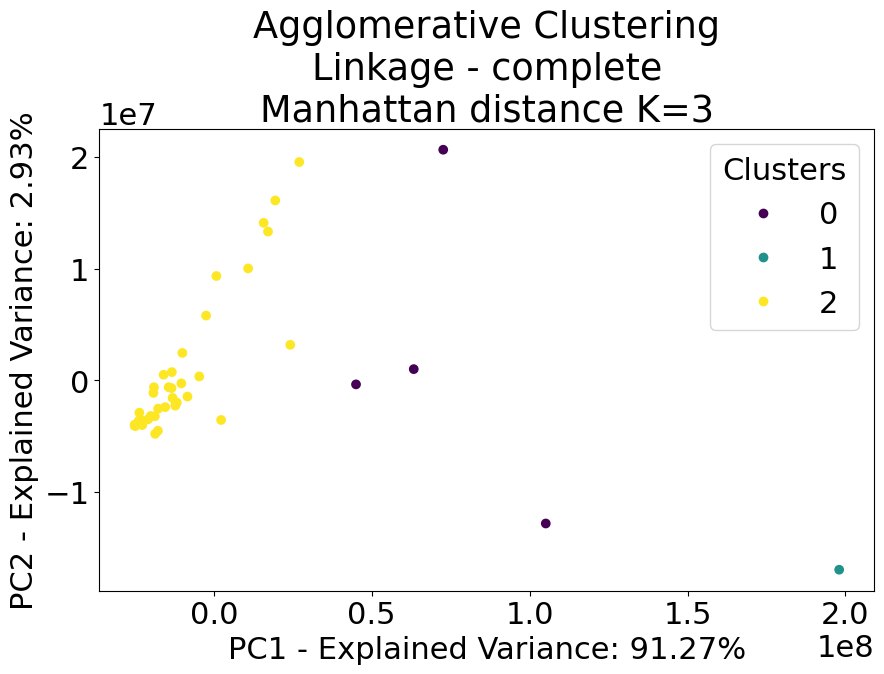

/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/83065664.py:88: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cos_sim_mat,'complete')


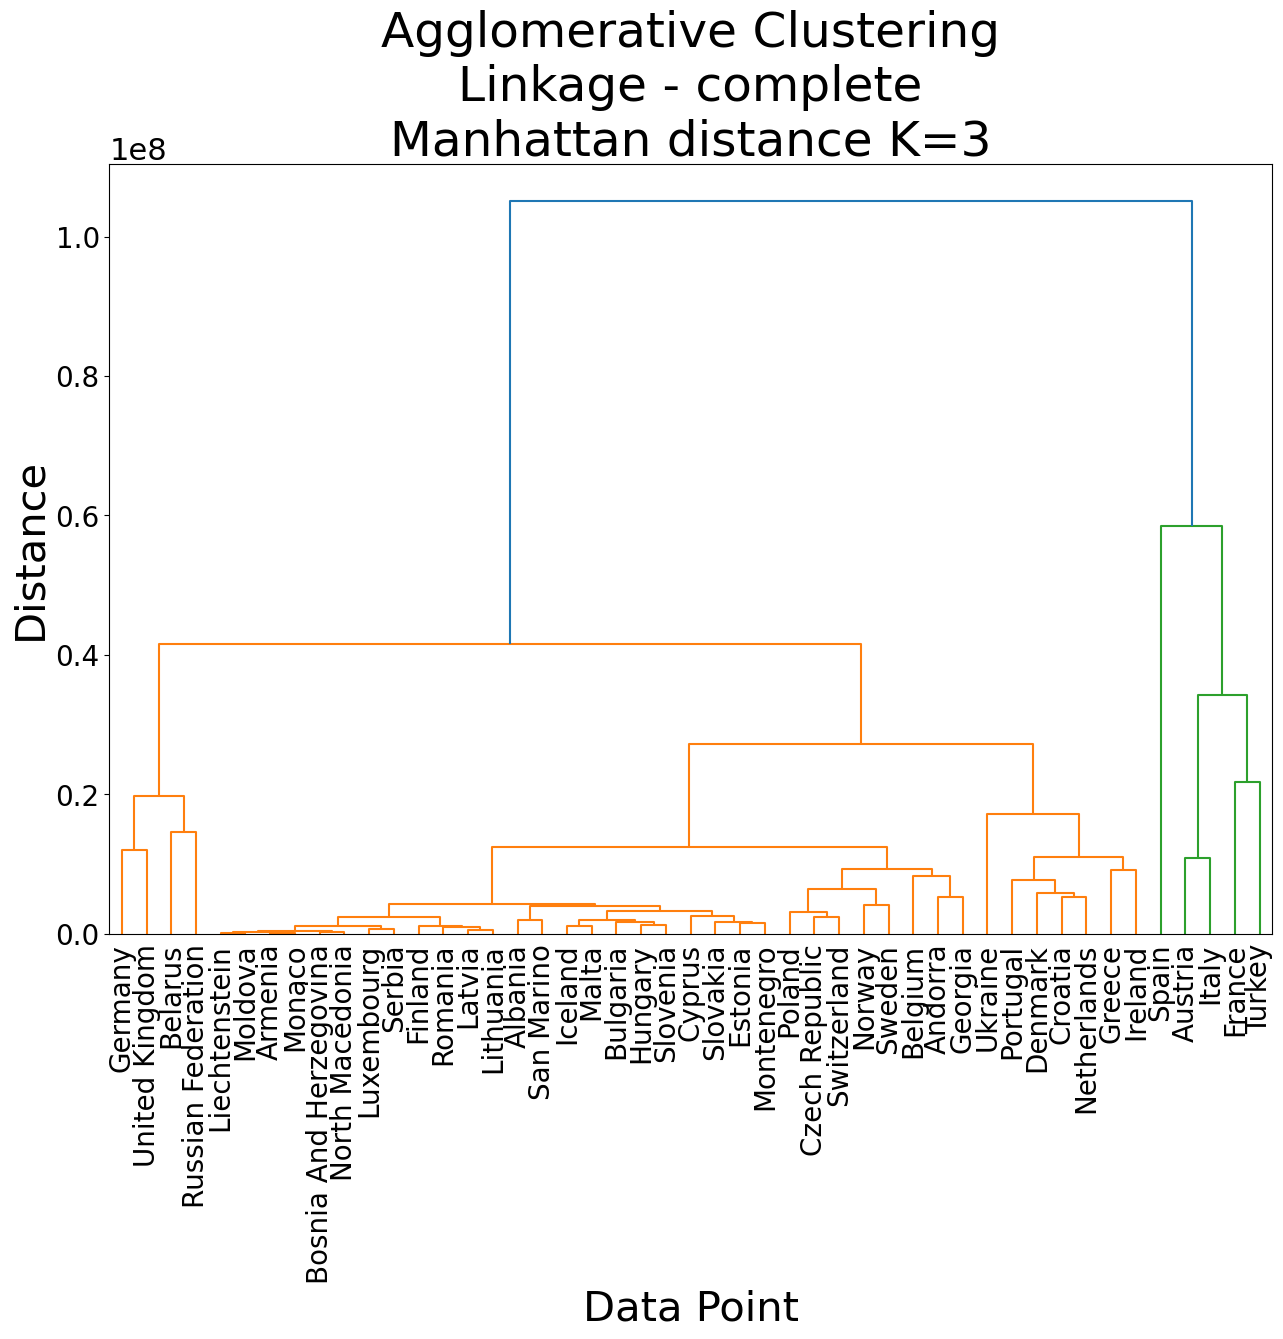

In [44]:
#AGGLOMERATIVE CLUSTERING - THE MODEL

#MANHATTAN DISTANCE K=3 clusters
rad_sim_mat = manhattan_distances(rad_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 10):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 10), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=3,linkage='complete')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('Model.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=9,value = "Agglomerative - Manhattan distance - K=3")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=9, value=labels[i])

# Save the workbook
workbook.save('Model.xlsx')

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19model.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=9,column=1,value = "Agglomerative - Manhattan distance - K=3")
scoresheet.cell(row=9, column=2, value=score)

# Save the workbook
scorebook.save('Scores19model.xlsx')

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - complete"+ "\n"+  "Manhattan distance K=3")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')

# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
file_name = 'agglo_manhattan_3_model.jpg'
save_image_path = os.path.join(save_model_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()


#Plot the dendrogram
Z = linkage(cos_sim_mat,'complete')
fig,ax = plt.subplots(figsize=(15,10))
dendrogram(Z,ax=ax,labels=df_Names['Country'].values)
ax.set_xlabel('Data Point', fontsize=30)
ax.set_ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering" + "\n" + "Linkage - complete"+ "\n"+  "Manhattan distance K=3", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Model/dendro_agglo_k3_19.png', bbox_inches='tight')
plt.show()



## EVALUATE THE DATA:

### Euclidean Distance

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

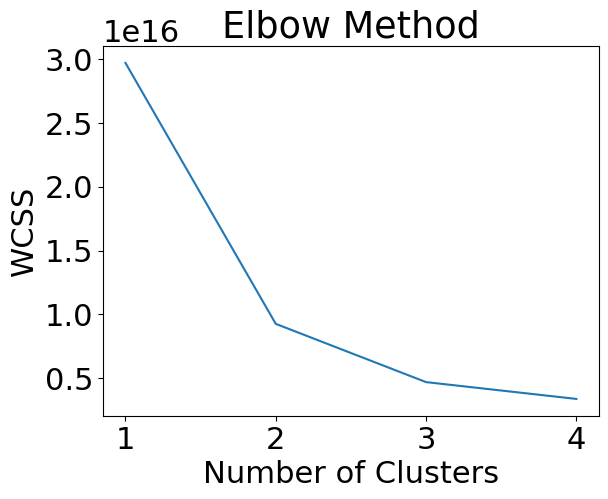

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/1524780058.py:70: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cos_sim_mat,'ward')


Node 0 is assigned to cluster 0
Node 1 is assigned to cluster 0
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 1
Node 4 is assigned to cluster 0
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 0
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster 0
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 1
Node 15 is assigned to cluster 0
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster 0
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster 0
Node 30 is assigned 

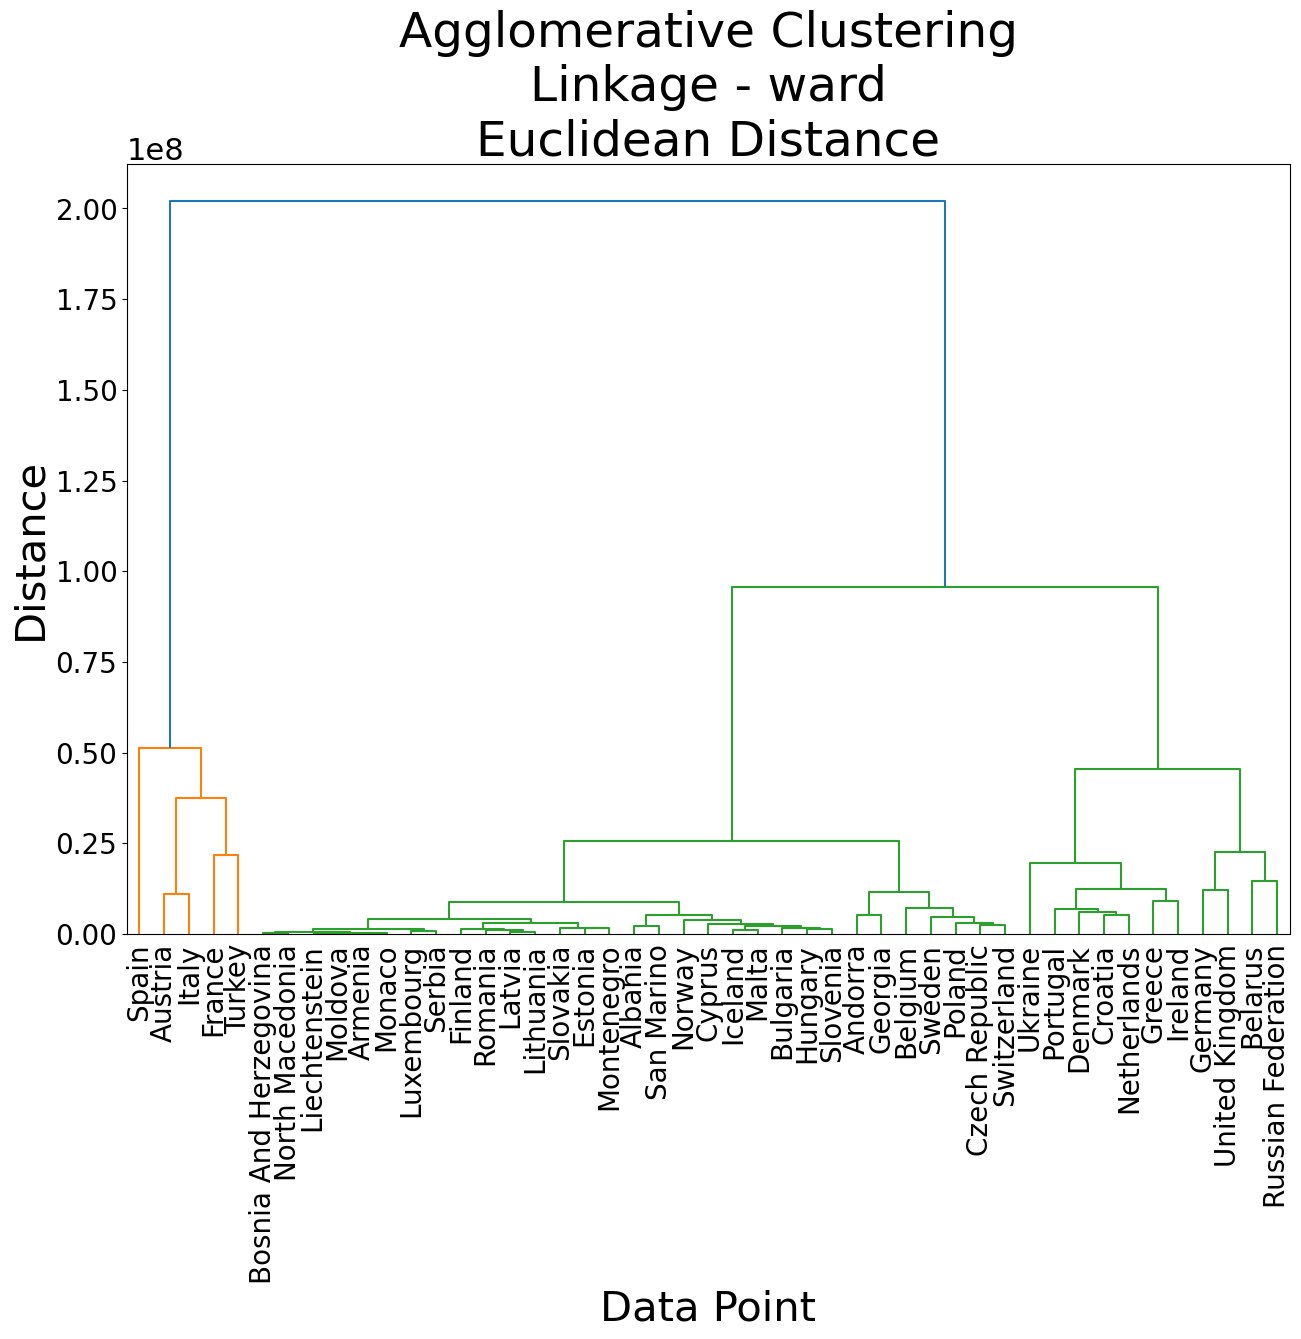

PC1 Explained Variance: 92.29%
PC2 Explained Variance: 2.73%


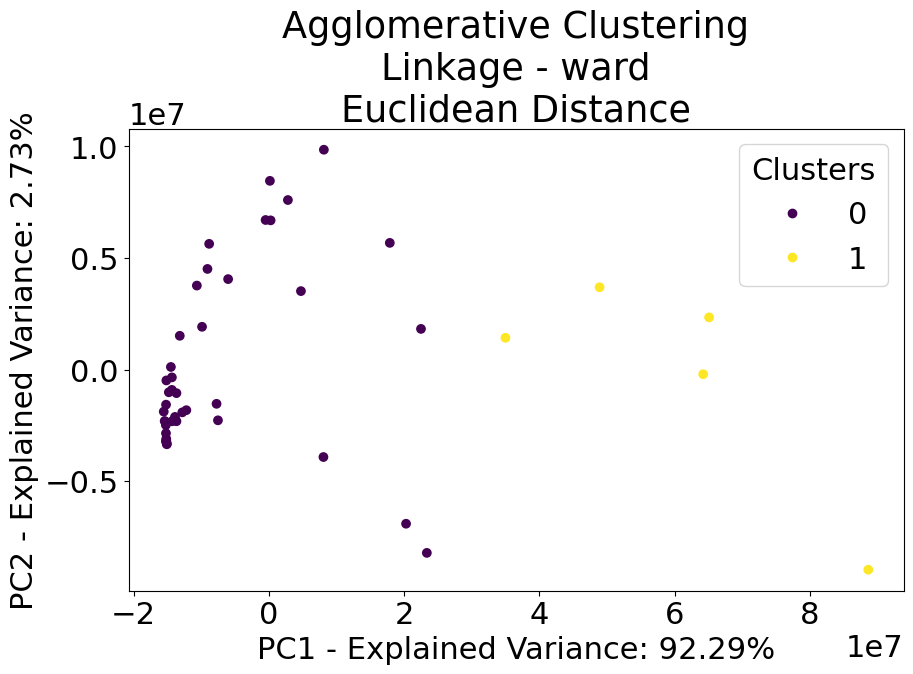

In [43]:
#AGGLOMERATIVE CLUSTERING - DATA

#EUCLIDEAN DISTANCE

cos_sim_mat = euclidean_distances(coef_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 5):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(cos_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(cos_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((cos_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 5), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='ward')
labels = model.fit_predict(cos_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(cos_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(cos_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=6,value = "Agglomerative - Euclidean distance")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=6, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=6,column=1,value = "Agglomerative -Euclidean distance")
scoresheet.cell(row=6, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')


#Plot the dendrogram
Z = linkage(cos_sim_mat,'ward')
fig,ax = plt.subplots(figsize=(15,10))
dendrogram(Z,ax=ax,labels=df_Names['Country'].values)
ax.set_xlabel('Data Point', fontsize=30)
ax.set_ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Euclidean Distance", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Data/dendro_euc_19.png', bbox_inches='tight')
plt.show()




# Visualize clusters using PCA
pca = PCA(n_components=2)
cos_sim_pca = pca.fit_transform(cos_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(cos_sim_pca[:, 0], cos_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Euclidean Distance")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')


file_name = 'agglo_euclidean_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()





### Cosine Similarity

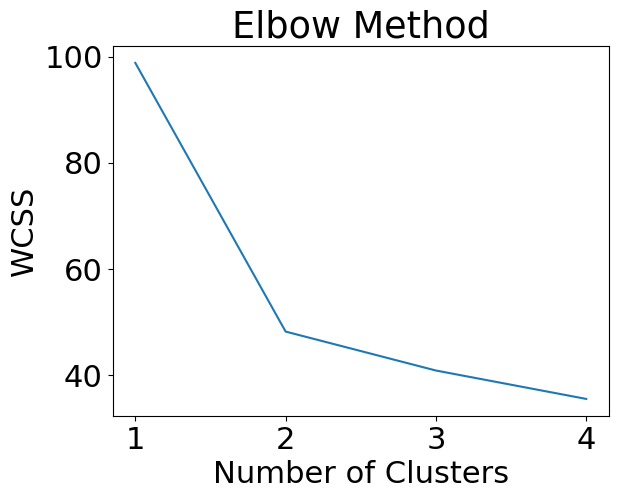

Node 0 is assigned to cluster 0
Node 1 is assigned to cluster 0
Node 2 is assigned to cluster 1
Node 3 is assigned to cluster 1
Node 4 is assigned to cluster 0
Node 5 is assigned to cluster 1
Node 6 is assigned to cluster 0
Node 7 is assigned to cluster 1
Node 8 is assigned to cluster 1
Node 9 is assigned to cluster 1
Node 10 is assigned to cluster 1
Node 11 is assigned to cluster 1
Node 12 is assigned to cluster 0
Node 13 is assigned to cluster 1
Node 14 is assigned to cluster 1
Node 15 is assigned to cluster 0
Node 16 is assigned to cluster 1
Node 17 is assigned to cluster 1
Node 18 is assigned to cluster 1
Node 19 is assigned to cluster 1
Node 20 is assigned to cluster 1
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 1
Node 23 is assigned to cluster 1
Node 24 is assigned to cluster 1
Node 25 is assigned to cluster 1
Node 26 is assigned to cluster 1
Node 27 is assigned to cluster 0
Node 28 is assigned to cluster 1
Node 29 is assigned to cluster 0
Node 30 is assigned 

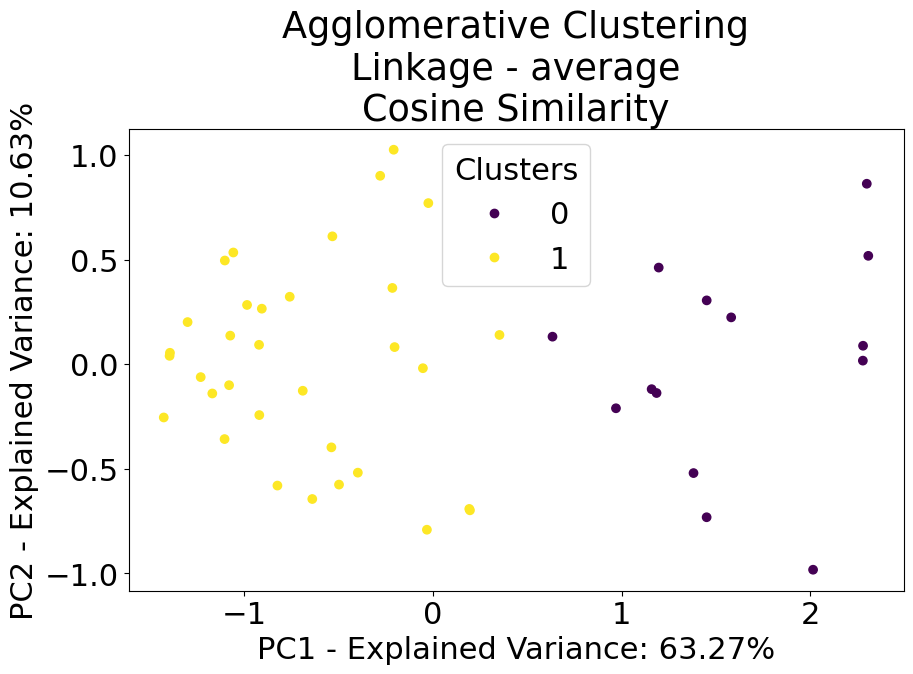

In [49]:
#AGGLOMERATIVE CLUSTERING - THE data

## COSINE SIMILARITY
rad_sim_mat = cosine_similarity(coef_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 5):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 5), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='average')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=7,value = "Agglomerative - Cosine Similarity")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=7, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')

# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=7,column=1,value = "Agglomerative - Cosine Similarity")
scoresheet.cell(row=7, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(*scatter.legend_elements(), title="Clusters")
# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - average"+ "\n"+  "Cosine Similarity")
file_name = 'agglo_cos_sim_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

### MANHATTAN DISTANCE K=2 

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

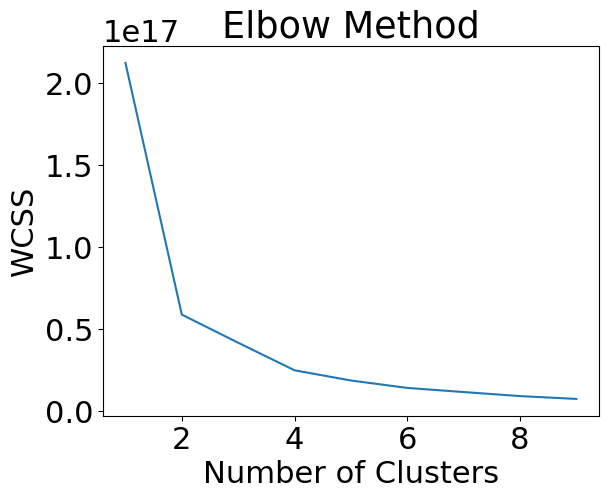

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/2048538666.py:55: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(rad_sim_mat,'ward')


Node 0 is assigned to cluster 0
Node 1 is assigned to cluster 0
Node 2 is assigned to cluster 0
Node 3 is assigned to cluster 1
Node 4 is assigned to cluster 0
Node 5 is assigned to cluster 0
Node 6 is assigned to cluster 0
Node 7 is assigned to cluster 0
Node 8 is assigned to cluster 0
Node 9 is assigned to cluster 0
Node 10 is assigned to cluster 0
Node 11 is assigned to cluster 0
Node 12 is assigned to cluster 0
Node 13 is assigned to cluster 0
Node 14 is assigned to cluster 1
Node 15 is assigned to cluster 0
Node 16 is assigned to cluster 1
Node 17 is assigned to cluster 0
Node 18 is assigned to cluster 0
Node 19 is assigned to cluster 0
Node 20 is assigned to cluster 0
Node 21 is assigned to cluster 1
Node 22 is assigned to cluster 0
Node 23 is assigned to cluster 0
Node 24 is assigned to cluster 0
Node 25 is assigned to cluster 0
Node 26 is assigned to cluster 0
Node 27 is assigned to cluster 0
Node 28 is assigned to cluster 0
Node 29 is assigned to cluster 0
Node 30 is assigned 

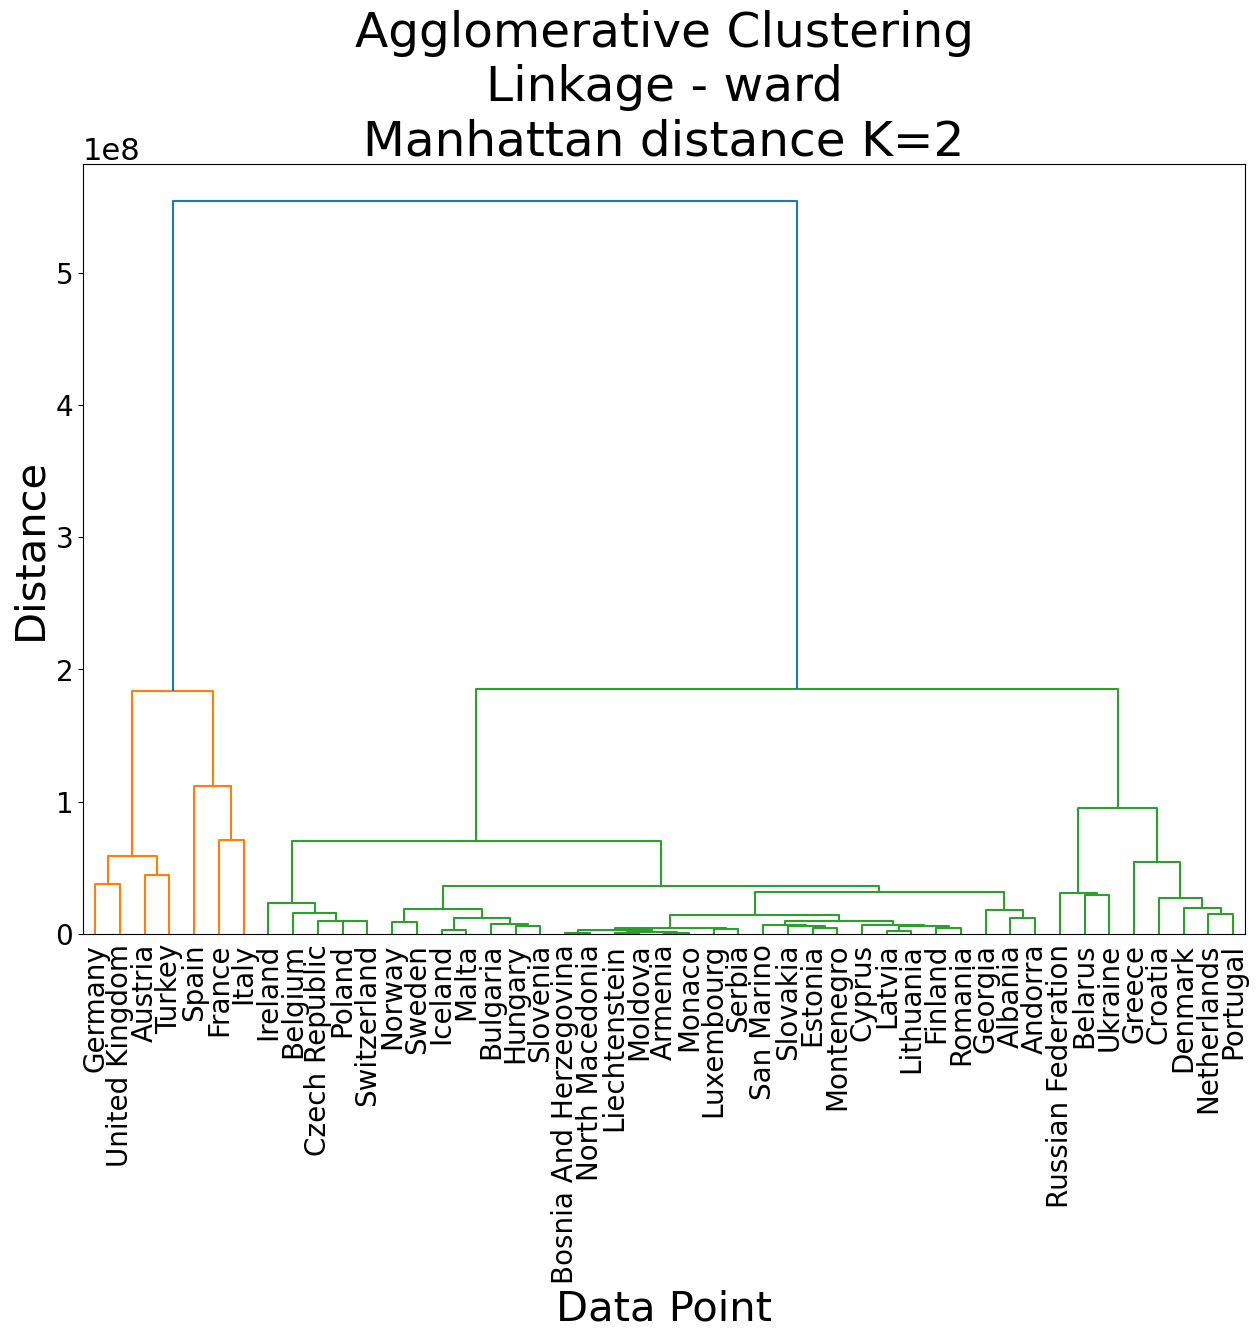

Silhouette score: 0.7430208470570246
PC1 Explained Variance: 92.09%
PC2 Explained Variance: 3.25%


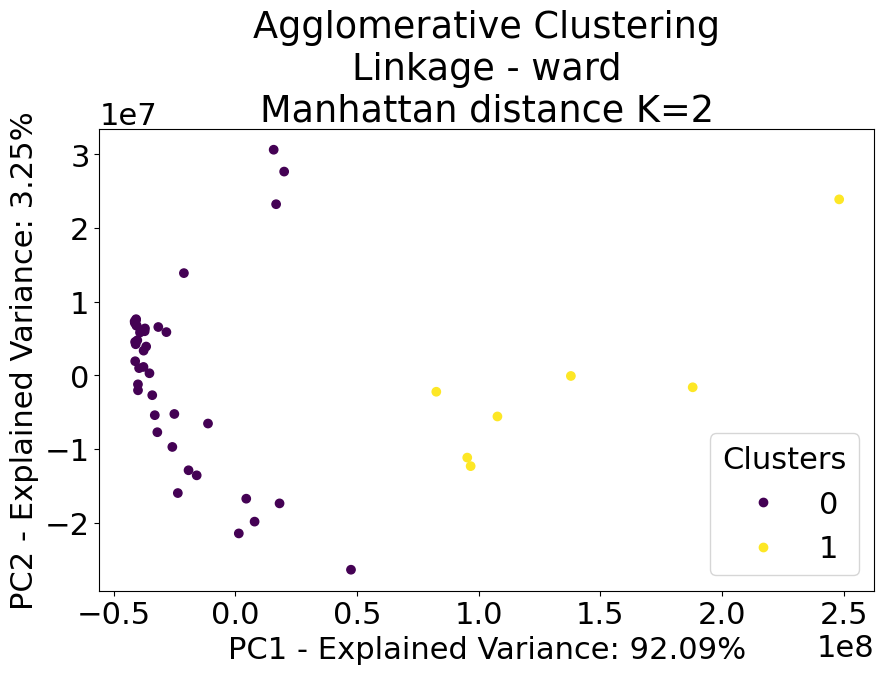

In [42]:
#AGGLOMERATIVE CLUSTERING - THE data

#MANHATTAN DISTANCE K=2 clusters
rad_sim_mat = manhattan_distances(coef_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 10):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 10), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=2,linkage='ward')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=8,value = "Agglomerative - Manhattan distance K=2")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=8, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')


#Plot the dendrogram
Z = linkage(rad_sim_mat,'ward')
fig,ax = plt.subplots(figsize=(15,10))
dendrogram(Z,ax=ax,labels=df_Names['Country'].values)
ax.set_xlabel('Data Point', fontsize=30)
ax.set_ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering"  + "\n" + "Linkage - ward"+ "\n"+ "Manhattan distance K=2", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Data/dendro_agglo_k2_19.png', bbox_inches='tight')
plt.show()


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')

# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=8,column=1,value = "Agglomerative - Manhattan distance K=2")
scoresheet.cell(row=8, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')


# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)


# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering"  + "\n" + "Linkage - ward"+ "\n"+  "Manhattan distance K=2")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - ward"+ "\n"+  "Manhattan distance K=2")
file_name = 'agglo_manhattan_2_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()


### MANHATTAN DISTANCE K=3

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The sym

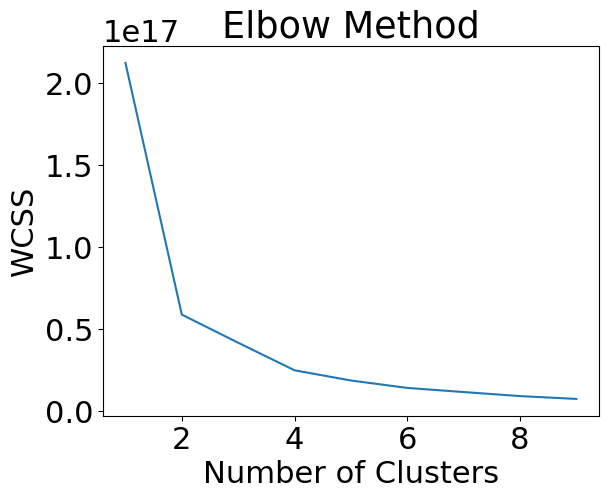

/Users/farrukh/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/var/folders/hg/fpblc7k913j_8cmp6vhqkyxw0000gn/T/ipykernel_59078/2075330795.py:72: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(rad_sim_mat, method='complete')


Node 0 is assigned to cluster 1
Node 1 is assigned to cluster 1
Node 2 is assigned to cluster 1
Node 3 is assigned to cluster 0
Node 4 is assigned to cluster 1
Node 5 is assigned to cluster 1
Node 6 is assigned to cluster 1
Node 7 is assigned to cluster 1
Node 8 is assigned to cluster 1
Node 9 is assigned to cluster 1
Node 10 is assigned to cluster 1
Node 11 is assigned to cluster 1
Node 12 is assigned to cluster 1
Node 13 is assigned to cluster 1
Node 14 is assigned to cluster 0
Node 15 is assigned to cluster 1
Node 16 is assigned to cluster 0
Node 17 is assigned to cluster 1
Node 18 is assigned to cluster 1
Node 19 is assigned to cluster 1
Node 20 is assigned to cluster 1
Node 21 is assigned to cluster 0
Node 22 is assigned to cluster 1
Node 23 is assigned to cluster 1
Node 24 is assigned to cluster 1
Node 25 is assigned to cluster 1
Node 26 is assigned to cluster 1
Node 27 is assigned to cluster 1
Node 28 is assigned to cluster 1
Node 29 is assigned to cluster 1
Node 30 is assigned 

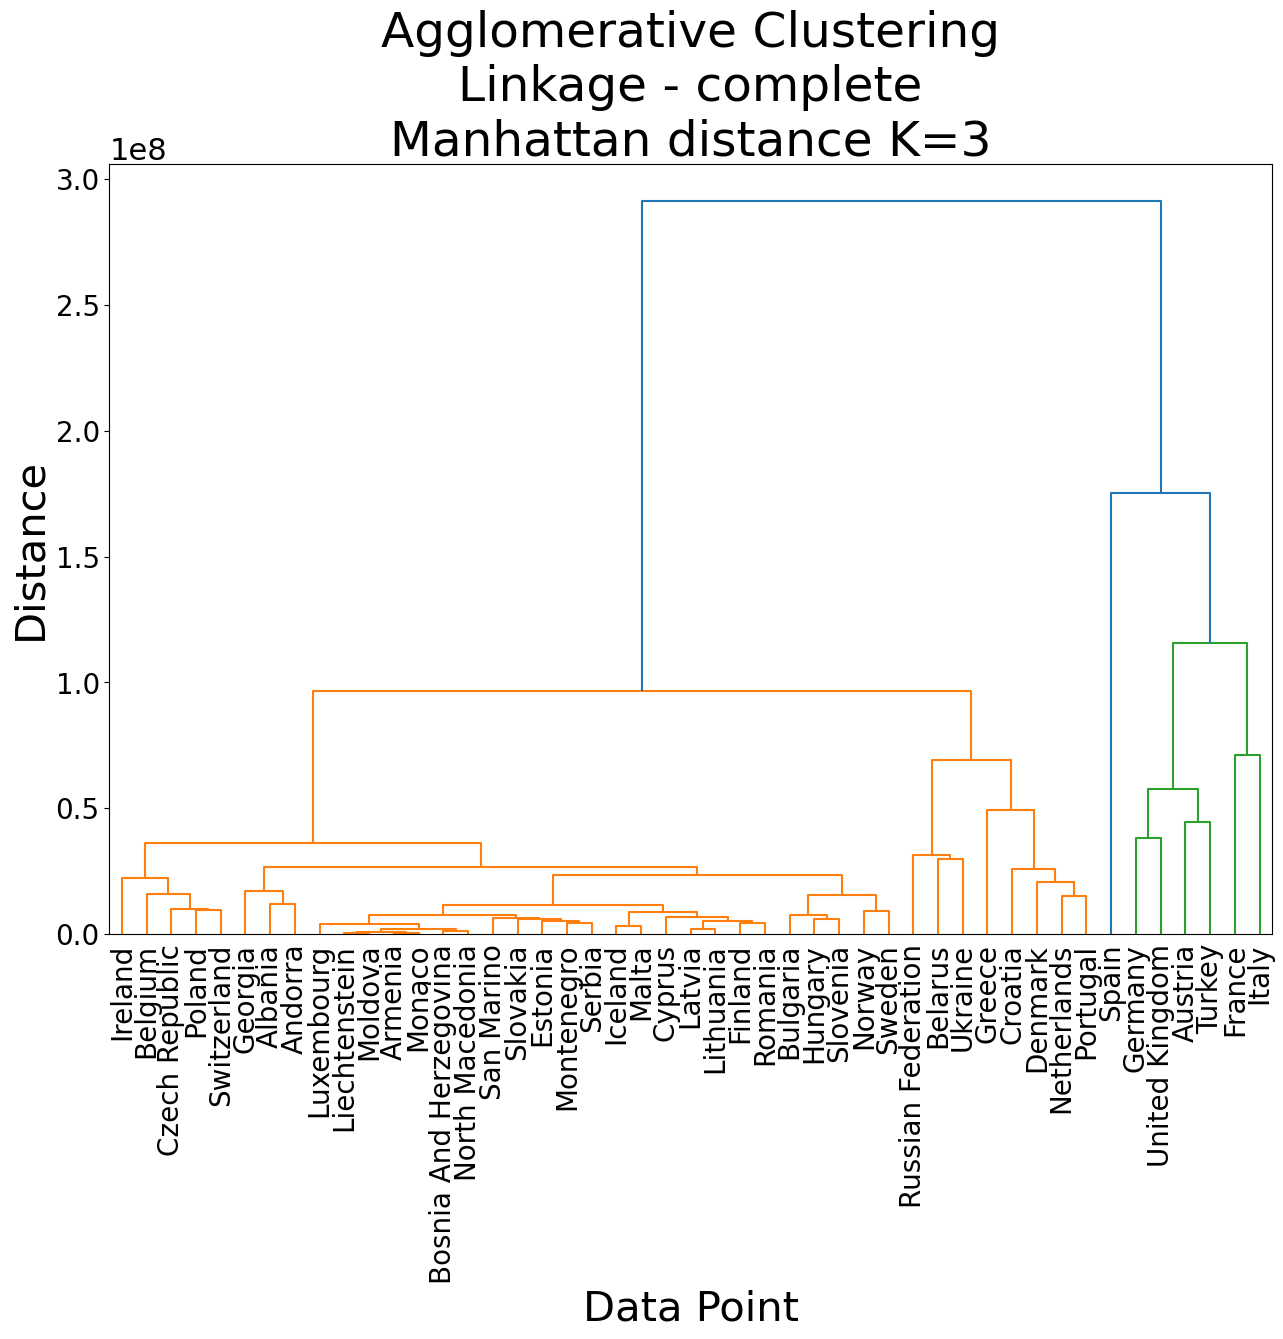

PC1 Explained Variance: 92.09%
PC2 Explained Variance: 3.25%


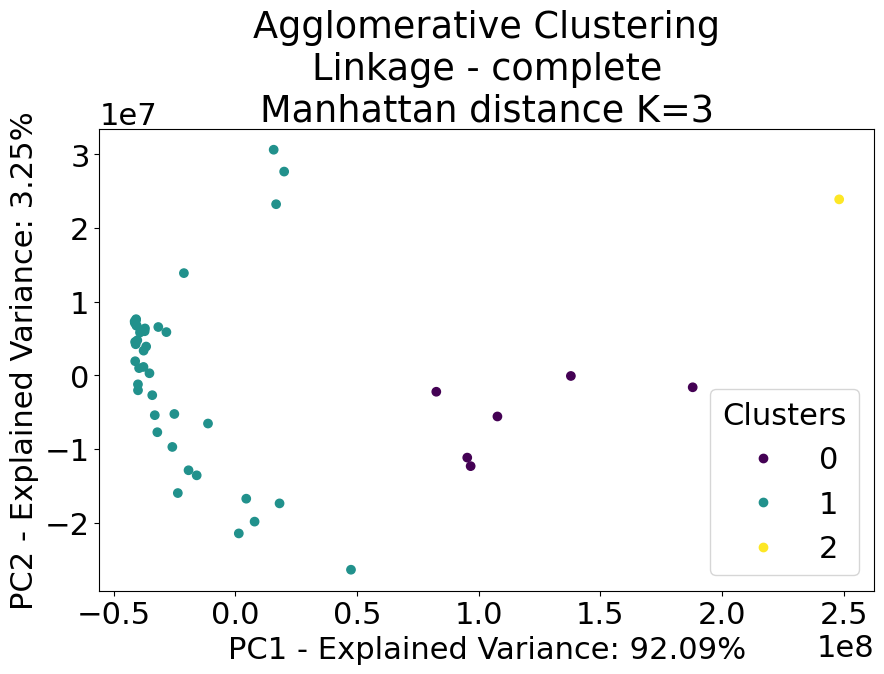

In [39]:
#AGGLOMERATIVE CLUSTERING - THE data

#MANHATTAN DISTANCE K=3 clusters
rad_sim_mat = manhattan_distances(coef_mat)

# Compute elbow score for different number of clusters
elbow_scores = []
for n_clusters in range(1, 10):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(rad_sim_mat)
    centers = []
    for i in range(n_clusters):
        centers.append(rad_sim_mat[labels == i].mean(axis=0))
    centers = np.vstack(centers)
    wcss = ((rad_sim_mat - centers[labels]) ** 2).sum()
    elbow_scores.append(wcss)

# Plot the elbow curve
plt.plot(range(1, 10), elbow_scores)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.rcParams.update({'font.size': 22})
plt.show()

# Perform agglomerative clustering with k clusters
model = AgglomerativeClustering(n_clusters=3,linkage='complete')
labels = model.fit_predict(rad_sim_mat)

# Print the cluster labels for each node or edge
for i in range(len(rad_sim_mat)):
    print("Node", i, "is assigned to cluster", labels[i])
print(labels)

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

# Load the workbook
workbook = openpyxl.load_workbook('DATA.xlsx')

# Select the worksheet
worksheet = workbook.active

# Add the cluster labels to the worksheet
worksheet.cell(row=1,column=9,value = "Agglomerative - Manhattan distance - K=3")
for i in range(len(labels)):
    worksheet.cell(row=i+2, column=9, value=labels[i])

# Save the workbook
workbook.save('DATA.xlsx')


# Load the workbook
scorebook = openpyxl.load_workbook('Scores19data.xlsx')


# Select the worksheet
scoresheet = scorebook.active

# Add the cluster labels to the worksheet
scoresheet.cell(row=9,column=1,value = "Agglomerative - Manhattan distance K=3")
scoresheet.cell(row=9, column=2, value=score)

# Save the workbook
scorebook.save('Scores19data.xlsx')

# Calculate silhouette score
score = silhouette_score(rad_sim_mat, labels)
print("Silhouette score:", score)

Z = linkage(rad_sim_mat, method='complete')
fig,ax = plt.subplots(figsize=(15,10))
dendrogram(Z,ax=ax,labels=df_Names['Country'].values, color_threshold=150000000)
ax.set_xlabel('Data Point', fontsize=30)
ax.set_ylabel('Distance', fontsize=30)
plt.title("Agglomerative Clustering" + "\n" + "Linkage - complete"+ "\n"+ "Manhattan distance K=3", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/Dendrogram/Data/dendro_agglo_k3_19.png', bbox_inches='tight')
plt.show()

# Visualize clusters using PCA
pca = PCA(n_components=2)
rad_sim_pca = pca.fit_transform(rad_sim_mat)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rad_sim_pca[:, 0], rad_sim_pca[:, 1], c=labels, cmap='viridis')
plt.title("Agglomerative Clustering" + "\n" + "Linkage - complete"+ "\n" +  "Manhattan distance K=3")
plt.legend(*scatter.legend_elements(), title="Clusters")
# Add x and y labels with explained variance
plt.xlabel(f'PC1 - Explained Variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 - Explained Variance: {pca.explained_variance_ratio_[1]:.2%}')
# Print the explained variance for each PC
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i + 1} Explained Variance: {var:.2%}')
file_name = 'agglo_manhattan_3_data.jpg'
save_image_path = os.path.join(save_data_image_path, file_name)
plt.savefig(save_image_path, format='jpg', dpi=300, bbox_inches='tight')  
plt.show()



# ======================== Save PCAs =========================

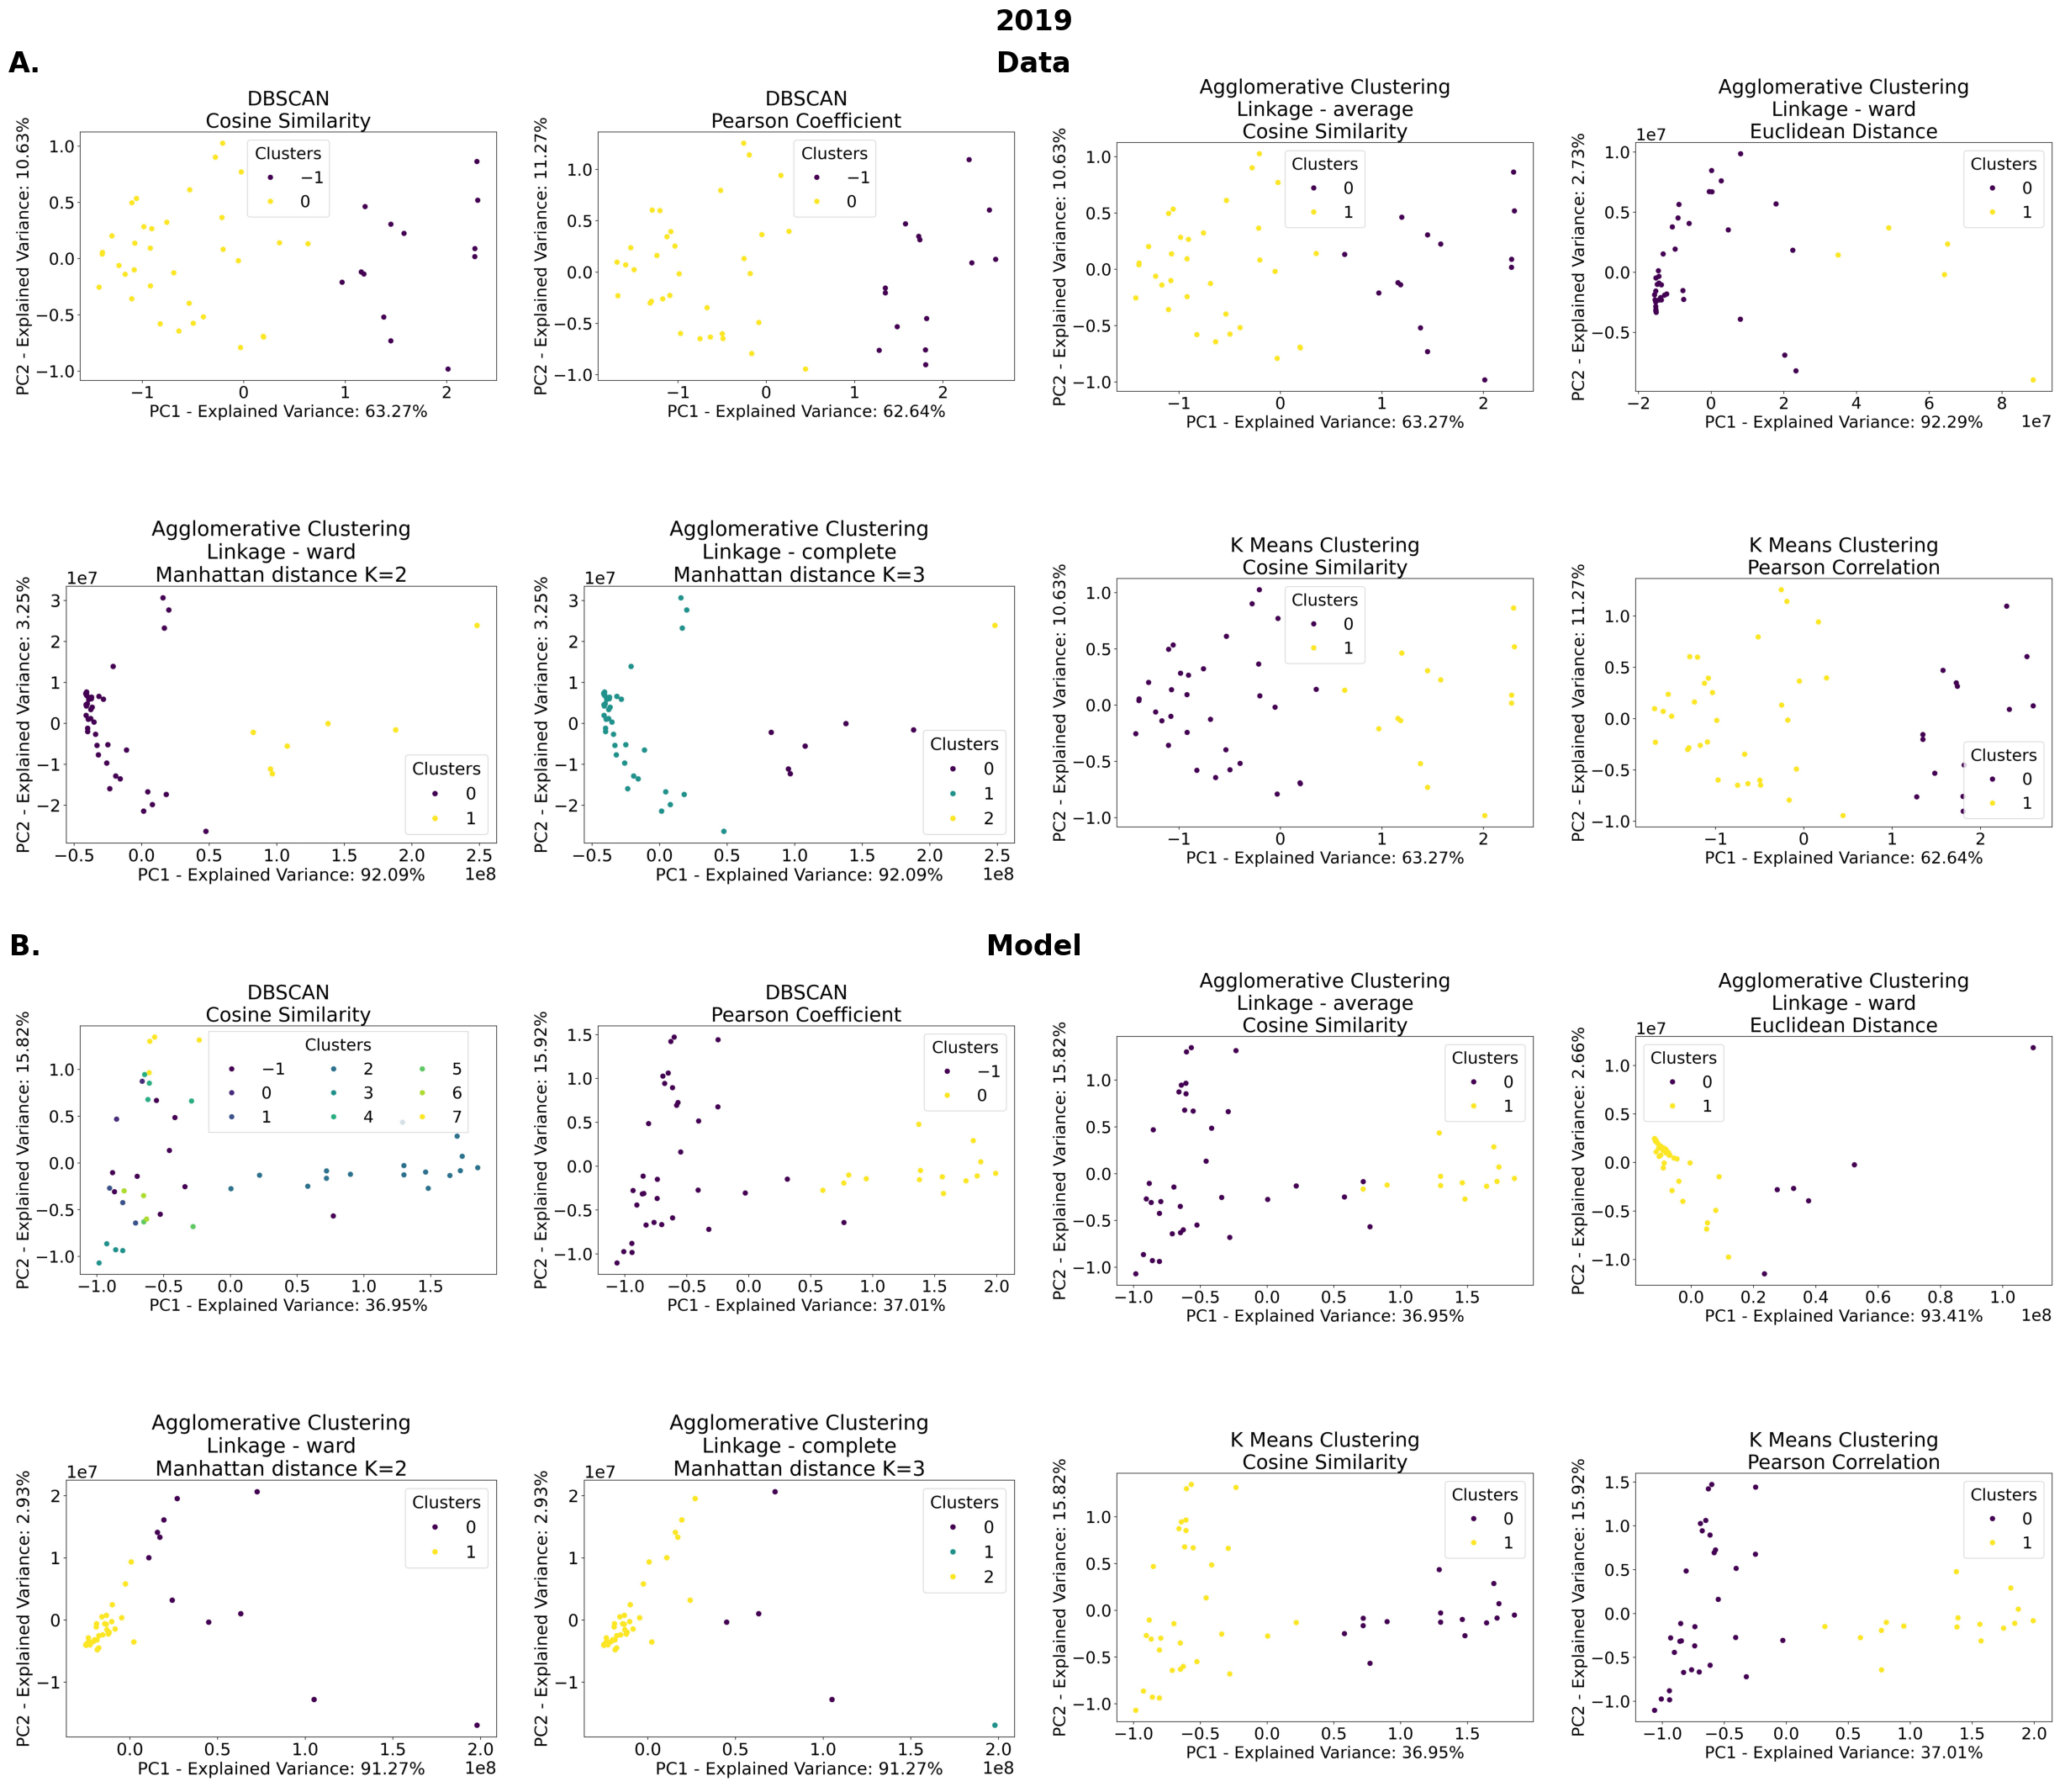

In [52]:
# Get the list of image filenames in each folder
image_files_folder1 = sorted([f for f in os.listdir(save_data_image_path) if f.endswith('.jpg')])
image_files_folder2 = sorted([f for f in os.listdir(save_model_image_path) if f.endswith('.jpg')])

# Create a 8x4 grid for subplots
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=2)
# Loop through the images in folder1 and display them in the grid
for i in range(8):
    img_path = os.path.join(save_data_image_path, image_files_folder1[i])
    img = mpimg.imread(img_path)
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].axis('off')

# Loop through the images in folder2 and display them in the grid
for i in range(8, 16):
    img_path = os.path.join(save_model_image_path, image_files_folder2[i - 16])
    img = mpimg.imread(img_path)
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].axis('off')


# Add titles for the first 2x4 and the next 2x4 in the center of the images
title_font = {'weight': 'bold', 'size': 24}  

# Title for the first 2x4
fig.text(0.5, 0.93, '2019', ha='center', va='center', **title_font)

# Title for the first 2x4
fig.text(0.5, 0.91, 'Data', ha='center', va='center', **title_font)
fig.text(0.02, 0.91, 'A.', ha='center', va='center', **title_font)


# Title for the next 2x4
fig.text(0.5, 0.49, 'Model', ha='center', va='center', **title_font)
fig.text(0.02, 0.49, 'B.', ha='center', va='center', **title_font)

plt.tight_layout()
plt.savefig('/Users/farrukh/Desktop/MA4M4 Topics in Complexity/Images_final_19/pca_19.png', bbox_inches='tight')
plt.show()
